# Raoul Herskovits Extract 10 Python Notebook

## Part 1: Package Importing, Data Cleaning and Reading
**Objectives**
1. Import Packages and Read the IPUMS microdata extract into a pandas DataFrame
2. Create new analytical columns which express relevant data and prepare it for future aggregation
3. Create a set of functions which will allow us to trim down future dataframes for visualization purposes
4. Create a set of Trimmed dataframes to assist with shapefile merging
5. Read the Enumeration District Shapefiles 
6. Aggregate our microdata based on Enumeration District, and merge them with their respective shapefiles into GeoDataFrames

### 1. Import Packages and Read the IPUMS microdata extract into a pandas DataFrame

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.ensemble import AdaBoostClassifier

from sklearn.metrics import r2_score
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import mean_squared_error

#### This file is an extract of census data from the Full Censuses of 1880 through 1940, isolated for only Kings County (Brooklyn) NY

The 1880 census information can help with broader analysis, but we will not be plotting it by enumeration district.

For more information about the extract, see the .cbk codebook file in the repository.


In [2]:
# Read In Our Data and take a peek
filepath = '/Users/raoulherskoits/Documents/GIS Work/BMT_Thesis/IPUMS/microdata_extract_11/usa_00011.csv'
df = pd.read_csv(filepath)

In [3]:
print("shape:", df.shape)
print('-------------')
print(df.dtypes)
print('-------------')
df.head()

shape: (7936470, 34)
-------------
YEAR             int64
SAMPLE           int64
SERIAL           int64
HHWT           float64
STATEFIP         int64
COUNTYICP        int64
GQ               int64
ENUMDIST         int64
PERNUM           int64
SEX              int64
AGE              int64
RACE             int64
RACED            int64
HISPAN           int64
HISPAND          int64
BPL              int64
BPLD             int64
MBPL             int64
MBPLD            int64
FBPL             int64
FBPLD            int64
NATIVITY         int64
OCC1950          int64
IND1950          int64
VERSIONHIST      int64
HISTID          object
MBPL_MOM       float64
MBPL_POP       float64
MBPL_MOM2      float64
MBPL_POP2      float64
FBPL_MOM       float64
FBPL_POP       float64
FBPL_MOM2      float64
FBPL_POP2      float64
dtype: object
-------------


,YEAR,SAMPLE,SERIAL,HHWT,STATEFIP,COUNTYICP,GQ,ENUMDIST,PERNUM,SEX,...,VERSIONHIST,HISTID,MBPL_MOM,MBPL_POP,MBPL_MOM2,MBPL_POP2,FBPL_MOM,FBPL_POP,FBPL_MOM2,FBPL_POP2
0,1880,188003,5999091,1.0,36,470,1,47000001,1,2,...,2,9FF5A2DD-D229-4B87-A50E-73957C2CFBC8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1880,188003,5999091,1.0,36,470,1,47000001,2,2,...,2,6E9CB7D7-4B60-4551-B3FF-2E05A4CC280A,36.0,NaN,NaN,NaN,36.0,NaN,NaN,NaN
2,1880,188003,5999091,1.0,36,470,1,47000001,3,2,...,2,F020F0B3-D539-43A5-9EFE-A6F5BCDF2E23,36.0,NaN,NaN,NaN,36.0,NaN,NaN,NaN
3,1880,188003,5999091,1.0,36,470,1,47000001,4,2,...,2,CA33FAA3-9408-4037-A56F-7F09851FFBD1,36.0,NaN,NaN,NaN,36.0,NaN,NaN,NaN
4,1880,188003,5999091,1.0,36,470,1,47000001,5,2,...,2,D0351FAD-DFF1-457A-82B1-D87F2AC514A2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 2. Create new analytical columns which express relevant data and prepare it for future aggregation

Our original file consists of microdata where all values in columns are codes referring to a specific classification.
Without overloading on a column because there are too many codes.

#### I. demographics

In [4]:
# make columns based on immigrant status
df['ISIMMIGRANT'] = ((df['NATIVITY']==5)|(df['BPL']>99)) #In case of error in the "nativity" entry, we also check if birthplace was outside of the USA
df['ISGENTWO'] = ((df['NATIVITY'].isin([2, 3, 4]))|(df['MBPL']>99)|(df['FBPL']>99)) #for the children of immigrants

In [5]:
# Make columns for our three primary Ethnic/Racial Groups
df['ISPR'] = (
    (df['HISPAN']==2) #Checking Hispanic census variable for "Puerto Rican" category
    |(df['MBPL']==110)|(df['FBPL']==110) #Checking if mother or father is born in PR
    |((df['FBPL_POP']==110)&(df['MBPL_POP']==110)) #Checking grandparents birthplaces for PR 
    |((df['FBPL_MOM']==110)&(df['MBPL_MOM']==110))
    )
df['ISWHITE'] = (
    (df['RACE']==1) 
    & ((df['HISPAND']==000)|(df['HISPAND']==480)) #Including people from Spain as white
    ) #Hispan 480 is Spanish, which we will include
df['ISBLACK'] = (df['RACE']==2)


Checking for ethnicity within white communities is more difficult, especially as we get to 1930 and 1940, when members of the italian community have parents both born in the united states. This should not exclude them from our "Italian" designation, so we check for grandparents birthplace as well.

In [6]:

# Italian Identity Groups
df['ITALYBPL'] = (df['BPL']==434)
df['ISITALIAN'] = (
    #Check for mothers, fathers, or own birthplace as italy
    (df['MBPL']==434)|(df['FBPL']==434)|(df['ITALYBPL']==1)
    # Check for grandparent birthplase as italy. 
    # We will say that if at least two grandparents were born in Italy, it counts.
    |((df['FBPL_POP']==434)&(df['MBPL_POP']==434))
    |((df['FBPL_MOM']==434)&(df['MBPL_MOM']==434))
                  )

df['ISWHITE_NON_ITALIAN'] = ((df['ISWHITE']==1)&(df['ISITALIAN']==0)).astype(int)

# German,  
df['ISGERMAN'] = (
    (df['BPL']==453)|(df['MBPL']==453)|(df['FBPL']==453)
    |((df['FBPL_POP']==453)&(df['MBPL_POP']==453))
    |((df['FBPL_MOM']==453)&(df['MBPL_MOM']==453))
    )

# Slavic
slav_codes = [452, 452, 455, 457, 465]
df['ISSLAVIC'] = (
    (df['BPL'].isin(slav_codes))|(df['MBPL'].isin(slav_codes))|(df['FBPL'].isin(slav_codes))
    |((df['FBPL_POP'].isin(slav_codes))&(df['MBPL_POP'].isin(slav_codes)))
    |((df['FBPL_MOM'].isin(slav_codes))&(df['MBPL_MOM'].isin(slav_codes)))
    )

# Irish,
df['ISIRISH'] = (
    (df['BPL']==414)|(df['MBPL']==414)|(df['FBPL']==414)
    |((df['FBPL_POP']==414)&(df['MBPL_POP']==414))
    |((df['FBPL_MOM']==414)&(df['MBPL_MOM']==414))
    )

# Scandinavian
scan_codes = list(range(400, 406))
df['ISSCANDI'] = (
    (df['BPL'].isin(scan_codes))|(df['MBPL'].isin(scan_codes))|(df['FBPL'].isin(scan_codes))
    |((df['FBPL_POP'].isin(scan_codes))&(df['MBPL_POP'].isin(scan_codes)))
    |((df['FBPL_MOM'].isin(scan_codes))&(df['MBPL_MOM'].isin(scan_codes)))
    )


# Compiling major groups into one
df['DEMO_GROUP'] = 0
df.loc[df['ISIMMIGRANT'], 'DEMO_GROUP'] = 1
df.loc[df['ISSLAVIC'], 'DEMO_GROUP'] = 2
df.loc[df['ISIRISH'], 'DEMO_GROUP'] = 3
df.loc[df['ISSCANDI'], 'DEMO_GROUP'] = 4
df.loc[df['ISGERMAN'], 'DEMO_GROUP'] = 5
df.loc[df['ISITALIAN'], 'DEMO_GROUP'] = 6
df.loc[df['ISBLACK'], 'DEMO_GROUP'] = 7
df.loc[df['ISPR'], 'DEMO_GROUP'] = 8


# Redefine our Demographic columns to eliminate overlap
df['IS_OTHER_NATIVE'] = (df['DEMO_GROUP']==0)
df['IS_OTHER_IMMIGRANT'] = (df['DEMO_GROUP']==1)
df['ISSLAVIC'] = (df['DEMO_GROUP']==2)
df['ISIRISH'] = (df['DEMO_GROUP']==3)
df['ISSCANDI'] = (df['DEMO_GROUP']==4)
df['ISGERMAN'] = (df['DEMO_GROUP']==5)
df['ISITALIAN'] = (df['DEMO_GROUP']==6)
df['ISBLACK'] = (df['DEMO_GROUP']==7)
df['ISPR'] = (df['DEMO_GROUP']==8)

df['DEMO_GROUP'].value_counts()


DEMO_GROUP
0    2225160
2    1549305
3    1068800
5    1005304
6     987149
1     625968
4     263646
7     192253
8      18885
Name: count, dtype: int64

#### II. employment

We start by separating the general occupation categories within the census (see the codebook for more details)

In [7]:
# make a column for people marked unemployed and people with no employment data

df['UNEMPLOYED'] = ((df['OCC1950'] < 997)&(df['OCC1950'] > 979)) #as it turns out, very few people are listed as unemployed
df['OCC_UNKNOWN'] = (df['OCC1950'].isin([999, 997]))


# Make a simplified version of the occupation data
df['OCC_CATEGORY'] = df['OCC1950']//100
df.loc[(df['UNEMPLOYED']), 'OCC_CATEGORY'] = 10
df.loc[(df['OCC_UNKNOWN']), 'OCC_CATEGORY'] = -1

# Get Dummies of this column, to isolate job category as a boolean variable per person
df['OCC_CATEGORY_DUMMY'] = df['OCC_CATEGORY']
df = pd.get_dummies(df, prefix=['OCC_CATEGORY'], columns=['OCC_CATEGORY_DUMMY'])

# Delete duplicates just in case
df = df.loc[:,~df.columns.duplicated()].copy()


Rename the dummies to reflect their category

In [8]:
del df['OCC_CATEGORY_-1'] # we already have OCC_UNKNOWN
del df['OCC_CATEGORY_10'] # we already have UNEMPLOYED
df = df.rename(columns={
    'OCC_CATEGORY_0': 'OCC_PRO/TECH',
    'OCC_CATEGORY_1': 'OCC_FARM',
    'OCC_CATEGORY_2': 'OCC_MAN/OFF/PROP',
    'OCC_CATEGORY_3': 'OCC_CLERICAL',
    'OCC_CATEGORY_4': 'OCC_SALES',
    'OCC_CATEGORY_5': 'OCC_CRAFTS',
    'OCC_CATEGORY_6': 'OCC_OP',
    'OCC_CATEGORY_7': 'OCC_SERVICE',
    'OCC_CATEGORY_8': 'OCC_FARMLAB',
    'OCC_CATEGORY_9': 'OCC_LAB', 
})


In [9]:

# Make a column for people working on the docks themselves

# This is a more generous interpretation of who would be working on the docks, including the codes for:
# Longshoremen/Stevedores, Sailors/Deckhands), and those in "water transportation" Industry
# df['ISDOCKWORKER'] = ((df['OCC1950'].isin([940, 673]))|(df['IND1950']==546)).astype(int) 

# Our dockworker column will just be for people we are 100% sure are Longshoremen/Stevedores
df['ISDOCKWORKER'] = ((df['OCC1950']==940))



# Make a superset column for more general waterfront-related laborers

# Define generally waterfront-related job codes
# See Codebook for chosen occupations
waterfront_jobs = [940, 950, 673, 623]
# Let's do the same for waterfront-related industries
# See codebook for chosen industries 
waterfront_industries = [546, 506, 527, 378, 379]
# Create the column using both lists
df['ISWATERFRONT'] = ((df['OCC1950'].isin(waterfront_jobs)) | (df['IND1950'].isin(waterfront_industries)))


# Make a more accurate column for all industrial laborers

# list of general industrial labor categories
# See codebook
industrial_industries = [246, 307, 308, 318, 336, 337, 338, 346, 347, 357, 358, 367, 376, 378, 379, 399, 499, 506, 526, 527, 546, 568, 976, 673]

# We will count anyone who's Occupation falls within the "laborer" or "operative"
df['ISINDUSTRY'] = ((df['OCC_CATEGORY']==9) | (df['OCC_CATEGORY']==6) | (df['IND1950'].isin(industrial_industries)))


# Make a Column Aggregating These Job Categories

# since 'ISINDUSTRY' contains 'ISWATERFRONT' contains 'ISDOCKWORKER', we can do this by summing
df['JOB_GROUP'] = df[['ISINDUSTRY', 'ISWATERFRONT', 'ISDOCKWORKER']].sum(axis=1) + 1
# make a value for unemployed
df.loc[(df['JOB_GROUP']==1)&(df['UNEMPLOYED']), 'JOB_GROUP'] = 0
# make a value for unknown occupation
df.loc[df['OCC_UNKNOWN'], 'JOB_GROUP'] = -1

**Later, we make dummy columns for ALL occupation codes, but we cannot do this with a dataframe of this size, as it crashes python**

#### III. Other
Boolean Columns for Group Quarters status, Immigrant statuse, and Second Generation Immigrant Status (that is, if someone is the child of immigrants)

In [10]:
# make a column for whether or not they live in group quarters
df['ISGQ'] = (df['GQ']>2)



#### IV. Compound Columns
Because we will need to aggregate our data when we merge with our shapefiles, we will need columns that represent a combination of attributes, namely demographic and employment.

In [11]:
def checkboth(column1, column2):
    return ((df[column1]) & (df[column2])).astype(bool)

for demo in ['ISPR', 'ISWHITE', 'ISBLACK',
       'ITALYBPL', 'ISITALIAN', 'ISGERMAN', 'ISSLAVIC',
       'ISIRISH', 'ISSCANDI', 'IS_OTHER_NATIVE',
       'IS_OTHER_IMMIGRANT', 'ISGQ']:
    for category in ['UNEMPLOYED', 'OCC_UNKNOWN',
       'OCC_PRO/TECH', 'OCC_FARM', 'OCC_MAN/OFF/PROP', 'OCC_CLERICAL',
       'OCC_SALES', 'OCC_CRAFTS', 'OCC_OP', 'OCC_SERVICE', 'OCC_FARMLAB',
       'OCC_LAB', 'OCC_PRO/TECH', 'OCC_FARM', 'OCC_MAN/OFF/PROP',
       'OCC_CLERICAL', 'OCC_SALES', 'OCC_CRAFTS', 'OCC_OP', 'OCC_SERVICE',
       'OCC_FARMLAB', 'OCC_LAB', 'ISDOCKWORKER', 'ISWATERFRONT', 'ISINDUSTRY', 'ISGQ', 'ISIMMIGRANT']:
        df[f'{demo}_AND_{category}'] = checkboth(demo, category)
        # print(f'checked {demo} and {category}')


# Delete duplicates just in case
df = df.loc[:,~df.columns.duplicated()].copy()

/var/folders/4n/4pdlrj2d1cz9mxmqmxm71s1c0000gn/T/ipykernel_61370/1798383852.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{demo}_AND_{category}'] = checkboth(demo, category)
/var/folders/4n/4pdlrj2d1cz9mxmqmxm71s1c0000gn/T/ipykernel_61370/1798383852.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{demo}_AND_{category}'] = checkboth(demo, category)
/var/folders/4n/4pdlrj2d1cz9mxmqmxm71s1c0000gn/T/ipykernel_61370/1798383852.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result

### 3. Create a set of functions which will allow us to trim down future dataframes for visualization purposes
I'd like to isolate only data where job information has been recorded, but first we need to make sure that no specific group has been disproportionately unreported

#### Make a function which isolates only the primary demographic groups of this project's interest
This function will only be used for comparing these demographics, while the first dataframe will still be used for more general calculations

In [12]:
# A filtered dataframe which isolates our six primary demographic groups
def reduce_demographic(df):
    return df[df['DEMO_GROUP']>1]

#### Make a function which drops all rows of unrecorded occupation
As we can see in the below graph, the recorded/unrecorded ration is generally even accross demographic group

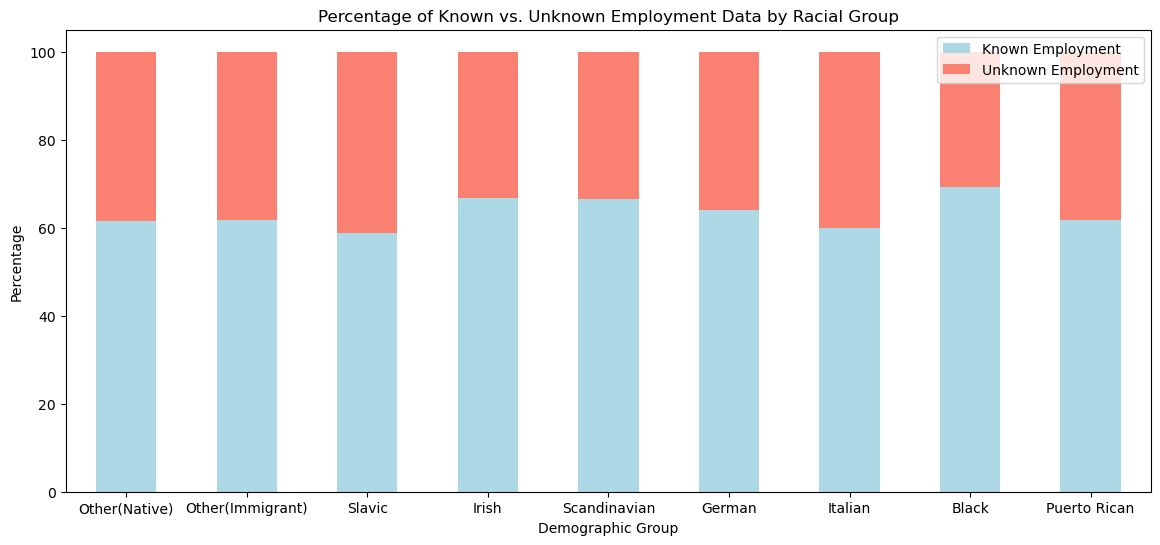

In [13]:
# Make a graph depicting count of each racial group unemployed or uncategorized


# Group by DEMO_GROUP and OCC_UNKNOWN to count occurrences
group_counts = df.groupby(['DEMO_GROUP', 'OCC_UNKNOWN']).size().unstack()

# Calculate the percentage of known and unknown data for each racial group
group_percentages = group_counts.div(group_counts.sum(axis=1), axis=0) * 100

# Plot the stacked bar chart
group_percentages.plot(kind='bar', stacked=True, color=['lightblue', 'salmon'], figsize=(14, 6))

# Customize the plot
plt.title("Percentage of Known vs. Unknown Employment Data by Racial Group")
plt.xlabel("Demographic Group")
plt.ylabel("Percentage")
plt.xticks(ticks=[0, 1, 2, 3, 4, 5, 6, 7, 8], 
           labels=["Other(Native)", "Other(Immigrant)", "Slavic", "Irish", "Scandinavian", "German", "Italian", "Black", "Puerto Rican"], rotation=0)  # Customizing tick labels
plt.legend(["Known Employment", "Unknown Employment"])

plt.show()



This function can be used for visualizing employed populations without having to drop unrecorded values every time. In general, though, we cannot eliminate these populations from our analysis.

In [14]:
def drop_unrecorded_jobs(df):
    return df[df['JOB_GROUP']!=-1]

### 4. Create a set of Trimmed dataframes to assist with shapefile merging

In [15]:
# dataframes separated by census year

df_1880 = df[df['YEAR']==1880] #this one is not really necessary
df_1900 = df[df['YEAR']==1900]
df_1910 = df[df['YEAR']==1910]
df_1920 = df[df['YEAR']==1920]
df_1930 = df[df['YEAR']==1930]
df_1940 = df[df['YEAR']==1940]

### 5. Read the Enumeration District Shapefiles and merge them with our DataFrame into a set of GeoDataFrames
Enumeration District labels and boundaries changed every decade, and do not currently exist in a digital shapefile format. Using AncestryLibrary and the National Archives, I have drawn each district in our area of interest and assigned them their correct labels. I have included these shapefiles in the repository both in their pure CRS form, and a projected form (EPSG:2263) which will be in this analysis to get an accurate calculation of polygon area.

More details on each year below.

#### 1900
These district boundaries were available through AncestryLibrary:

Ancestry.com. 1900 United States Federal Census [database on-line]. Lehi, UT, USA: Ancestry.com Operations Inc, 2004.

https://www.ancestrylibrary.com/search/collections/7602/

In [16]:
shp1900 = gpd.read_file('/Users/raoulherskoits/Documents/GIS Work/BMT_Thesis/shapefiles/enumeration_districts_1900/enumeration_districts_1900_projected.shp')
print(shp1900.head())

   1900label                                           geometry
0   47000168  POLYGON ((-74.01292 40.67732, -74.01142 40.676...
1   47000167  POLYGON ((-74.01416 40.67815, -74.01292 40.677...
2   47000169  POLYGON ((-74.01416 40.67815, -74.01224 40.679...
3   47000175  POLYGON ((-73.99873 40.67648, -73.99537 40.675...
4   47000176  POLYGON ((-74.00136 40.67575, -73.99933 40.675...


#### 1910
These district boundaries were available through AncestryLibrary:

Ancestry.com. 1910 United States Federal Census [database on-line]. Lehi, UT, USA: Ancestry.com Operations Inc, 2006.

https://www.ancestrylibrary.com/search/collections/7884/

In [17]:
shp1910 = gpd.read_file('/Users/raoulherskoits/Documents/GIS Work/BMT_Thesis/shapefiles/enumeration_districts_1910/enumeration_districts_1910_projected.shp')
shp1910.head()

,1910label,geometry
0,47000240,"POLYGON ((979896.566 184291.988, 979462.128 18..."
1,47000241,"POLYGON ((980559.089 185091.035, 980146.342 18..."
2,47000242,"POLYGON ((980321.809 186345.804, 981081.790 18..."
3,47000243,"POLYGON ((981191.829 186629.212, 981599.865 18..."
4,47000244,"POLYGON ((980853.954 186942.961, 981191.829 18..."


#### 1920
These district boundaries were available through AncestryLibrary:

Ancestry.com. 1920 United States Federal Census [database on-line]. Provo, UT, USA: Ancestry.com Operations, Inc., 2010. Images reproduced by FamilySearch.

https://www.ancestrylibrary.com/search/collections/6061/

In [18]:
shp1920 = gpd.read_file('/Users/raoulherskoits/Documents/GIS Work/BMT_Thesis/shapefiles/enumeration_districts_1920/enumeration_districts_1920_projected.shp')
shp1920.head()

,id,1920label,geometry
0,NaN,47000124,"POLYGON ((984125.152 190531.403, 984044.815 19..."
1,NaN,47000125,"POLYGON ((984840.877 189699.993, 984749.561 18..."
2,NaN,47000126,"POLYGON ((984749.561 189449.787, 984504.505 18..."
3,NaN,47000127,"POLYGON ((984537.453 189543.434, 984293.003 18..."
4,NaN,47000128,"POLYGON ((983869.702 189827.156, 984279.394 18..."


#### 1930

These district boundaries were available through AncestryLibrary:

Ancestry.com. 1930 United States Federal Census [database on-line]. Provo, UT, USA: Ancestry.com Operations Inc, 2002.

https://www.ancestrylibrary.com/search/collections/6224/

In [19]:
shp1930 = gpd.read_file('/Users/raoulherskoits/Documents/GIS Work/BMT_Thesis/shapefiles/enumeration_districts_1930/enumeration_districts_1930_projected.shp')

# I had included an etra feature, but we have no need for it
del shp1930['1940label']
shp1930.head()

,1930label,geometry
0,47001710,"POLYGON ((979804.375 185765.180, 979387.212 18..."
1,47000957,"POLYGON ((983236.142 188113.073, 982558.777 18..."
2,47000975,"POLYGON ((980853.954 186942.961, 981191.829 18..."
3,47000973,"POLYGON ((979804.375 185765.180, 979152.204 18..."
4,47001716,"POLYGON ((982825.375 182607.205, 983266.511 18..."


#### 1940

Comparing to the list of districts here:
https://www.ancestrylibrary.com/search/collections/2442/
we see that the majority of district names in the dataset end with 0 while most of the written ones end in another digit.

In [20]:
df.loc[(df['YEAR']==1940)&(df['ENUMDIST']%10 != 0)].groupby('ENUMDIST').size()

ENUMDIST
2400101    835
2400102    131
2400281    899
2400282    858
2400341    458
          ... 
2425902    103
2425921    893
2425922    669
2425931    130
2425932    188
Length: 714, dtype: int64

In [21]:
df.loc[(df['YEAR']==1940)&(df['ENUMDIST']%10 == 0)].groupby('ENUMDIST').size()

ENUMDIST
2400010    1307
2400020     360
2400030     352
2400040      15
2400050     868
           ... 
2428590     471
2428600     487
2428610     430
2428620     407
2428630     422
Length: 2446, dtype: int64

It seems as though district names are shifted one digit to the left to give room for another digit, used to designate a new differentiator used in this census: alphabetic codes at the end of some districts.

e.g. enumeration district 1025:
in the written districts, there are two districts 1025 (1025A and 1025B), and no districts 10251 or 10252. However in the dataset...

In [22]:
print(df.loc[(df['YEAR']==1940)&(df['ENUMDIST'] == 2401025)].groupby('ENUMDIST').size())
# There are no districts simply labeled 1025

print('\n ------------------- \n')

print(df.loc[(df['YEAR']==1940)&(df['ENUMDIST']//10==241025)].groupby('ENUMDIST').size())
# and there are are two districts 10251 and 10252!

Series([], dtype: int64)

 ------------------- 

ENUMDIST
2410251    793
2410252    723
dtype: int64


This seems to be strong evidence that the last digit is reserved to designate the alphabetic label, and the label is not eliminated.

We can try again with another district, 1031, which has three alphabetic designations: A, B, and C.

In [23]:
print('Rows with enumeration district ending in 1031:')

print(df.loc[(df['YEAR']==1940)&(df['ENUMDIST']%10000==1031)].groupby('ENUMDIST').size())

print('\n ------------------- \n')

print('Rows with enumeration district ending 1031 + another digit')
print(df.loc[(df['YEAR']==1940)&(df['ENUMDIST']//10==241031)].groupby('ENUMDIST').size())

Rows with enumeration district ending in 1031:
Series([], dtype: int64)

 ------------------- 

Rows with enumeration district ending 1031 + another digit
ENUMDIST
2410311    603
2410312    705
2410313    302
dtype: int64


As we can see, the final digit once again matches the three alphabetic labels perfectly

In [24]:
df.loc[(df['YEAR']==1930)&(df['DEMO_GROUP']==6),'ENUMDIST'].value_counts()

ENUMDIST
47001161    2520
47001430    2194
47001134    2010
47001770    1838
47001939    1555
            ... 
47000672       1
47000803       1
47001515       1
47000799       1
47000802       1
Name: count, Length: 1782, dtype: int64

With that knowledge, we can label our polygons correctly, and load them in.

In [25]:
shp1940 = gpd.read_file('/Users/raoulherskoits/Documents/GIS Work/BMT_Thesis/shapefiles/enumeration_districts_1940/enumeration_districts_1940_projected.shp')
shp1940.head()

,id,1940label,geometry
0,NaN,2404991,"POLYGON ((981081.845 185673.296, 981599.865 18..."
1,NaN,2404992,"POLYGON ((981873.009 185718.879, 982007.688 18..."
2,NaN,2404993,"POLYGON ((982361.124 186270.009, 982700.143 18..."
3,NaN,2404994,"POLYGON ((981873.009 185718.879, 981939.408 18..."
4,NaN,2404930,"POLYGON ((979804.375 185765.180, 979387.212 18..."


#### Special Districts: Hostpitals/Schools
There are a set of districts which are better mapped by points as opposed to polygons, as they refer to the property of specific institutions. Because they cannot be mapped in the same way as the other data, and only refer to special cases such as hospitals, universities, and churches (ostensibly removed from the industrial waterfront), I have refrained from incoorperating them in this analysis.

### 6. Aggregate our microdata based on Enumeration District, and merge them with their respective shapefiles into GeoDataFrames

First, trim our Decade-Specific dataframes to only contain the data from our region of interest: Red Hook
And rename their enumeration district labels to match those of the shapefiles

In [26]:
df_1900_redhook = df_1900[df_1900['ENUMDIST'].isin(shp1900['1900label'])]
df_1910_redhook = df_1910[df_1910['ENUMDIST'].isin(shp1910['1910label'])]
df_1920_redhook = df_1920[df_1920['ENUMDIST'].isin(shp1920['1920label'])]
df_1930_redhook = df_1930[df_1930['ENUMDIST'].isin(shp1930['1930label'])]
df_1940_redhook = df_1940[df_1940['ENUMDIST'].isin(shp1940['1940label'])]

df_redhook = pd.concat([df_1900_redhook, df_1910_redhook, df_1920_redhook, df_1930_redhook, df_1940_redhook], ignore_index=True)

#### Now, our dataframes are small enough to "get_dummies" i.e., make boolean columns, for all of our occupation codes.

In [28]:
def occdummies(df):
    # Make dummies for occupation in case of future aggregation
    df['OCC1950_DUMMY'] = df['OCC1950']
    df = pd.get_dummies(df, columns=['OCC1950_DUMMY'], prefix='OCC1950', dtype=int)
    
    # get rid of any duplicate columns
    df = df.loc[:,~df.columns.duplicated()].copy()

    return df

df_redhook = occdummies(df_redhook)

Now, we make a function which produces two dataframes using the previously created ones:
1. a dataframe which adds "dummy" columns for OCC1950
2. an aggregated dataframe which counts all of our dummies in each enumeration district

We will need to aggregate the grouped data before we merge with the shapefiles

In [29]:
def group_enum (df, shp, label):
    # # Make dummies for occupation in case of future aggregation
    # df['OCC1950_DUMMY'] = df['OCC1950']
    # dummydf = pd.get_dummies(df, columns=['OCC1950_DUMMY'], prefix='OCC1950', dtype=int)
    
    # # Prep our new dataframe
    # df = dummydf.loc[:,~dummydf.columns.duplicated()].copy() #gets rid of duplicate columns
    df['TOTAL_POP'] = 1 #This can help in the future with counting population using aggregation
    df.rename(columns={'ENUMDIST': label}, inplace=True)
    
    # Drop all non-aggregatable columns and group by Enumeration District
    trimdf = df.drop(columns=['SAMPLE', 'SERIAL', 'HHWT', 'STATEFIP', 'COUNTYICP', 'GQ', 'PERNUM', 'SEX', 'AGE', 'RACE', 'RACED', 'HISPAN',
       'HISPAND', 'BPL', 'BPLD', 'MBPL', 'MBPLD', 'FBPL', 'FBPLD',
       'NATIVITY', 'OCC1950', 'IND1950', 'VERSIONHIST', 'HISTID',
       'MBPL_MOM', 'MBPL_POP', 'MBPL_MOM2', 'MBPL_POP2', 'FBPL_MOM',
       'FBPL_POP', 'FBPL_MOM2', 'FBPL_POP2', 'DEMO_GROUP', 'OCC_CATEGORY', 'JOB_GROUP'])
    # print(trimdf.head())
    aggdf = trimdf.groupby(label).sum().reset_index()
    # print(aggdf.columns[aggdf.columns.duplicated()])   for bugfixing
    return aggdf


df_1900_enumgroupsums = group_enum(df_1900_redhook, shp1900, '1900label')
df_1910_enumgroupsums = group_enum(df_1910_redhook, shp1910, '1910label')
df_1920_enumgroupsums = group_enum(df_1920_redhook, shp1920, '1920label')
df_1930_enumgroupsums = group_enum(df_1930_redhook, shp1930, '1930label')
df_1940_enumgroupsums = group_enum(df_1940_redhook, shp1940, '1940label')

/var/folders/4n/4pdlrj2d1cz9mxmqmxm71s1c0000gn/T/ipykernel_61370/407881742.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['TOTAL_POP'] = 1 #This can help in the future with counting population using aggregation
/var/folders/4n/4pdlrj2d1cz9mxmqmxm71s1c0000gn/T/ipykernel_61370/407881742.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={'ENUMDIST': label}, inplace=True)
/var/folders/4n/4pdlrj2d1cz9mxmqmxm71s1c0000gn/T/ipykernel_61370/407881742.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram

Finally, merge our aggregated dataframes with their corresponding shapefiles!

In [30]:
# A function to merge aggregated data with enumeration district shapefiles
def merge_enum(df, shp, label):
    merged_df = pd.merge(shp, df, on=label, how='inner')

    # Turn it into a GeoDataFrame
    gdf = gpd.GeoDataFrame(merged_df, geometry='geometry')

    # Reindex to turn the enumeration district label into a normal column
    gdf.reset_index(drop=True, inplace=True)

    # Make a column with the areas of each district (this will be useful later)
    gdf[f'{label[:4]}_AREA'] = gdf['geometry'].area

    return gdf

# Perform the function for our five censuses

gdf_1900 = merge_enum(df_1900_enumgroupsums, shp1900,label='1900label')
gdf_1910 = merge_enum(df_1910_enumgroupsums, shp1910,label='1910label')
gdf_1920 = merge_enum(df_1920_enumgroupsums, shp1920,label='1920label')
gdf_1930 = merge_enum(df_1930_enumgroupsums, shp1930,label='1930label')
gdf_1940 = merge_enum(df_1940_enumgroupsums, shp1940,label='1940label')

/var/folders/4n/4pdlrj2d1cz9mxmqmxm71s1c0000gn/T/ipykernel_61370/2068163712.py:12: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf[f'{label[:4]}_AREA'] = gdf['geometry'].area


In [31]:
gdf_1900.head()

,1900label,geometry,YEAR,ISIMMIGRANT,ISGENTWO,ISPR,ISWHITE,ISBLACK,ITALYBPL,ISITALIAN,...,ISGQ_AND_OCC_SERVICE,ISGQ_AND_OCC_FARMLAB,ISGQ_AND_OCC_LAB,ISGQ_AND_ISDOCKWORKER,ISGQ_AND_ISWATERFRONT,ISGQ_AND_ISINDUSTRY,ISGQ_AND_ISGQ,ISGQ_AND_ISIMMIGRANT,TOTAL_POP,1900_AREA
0,47000168,"POLYGON ((-74.01292 40.67732, -74.01142 40.676...",2451000,659,1146,0,1287,0,35,37,...,0,0,0,0,0,0,0,0,1290,0.000010
1,47000167,"POLYGON ((-74.01416 40.67815, -74.01292 40.677...",2804400,816,1330,0,1472,0,36,43,...,4,0,0,0,5,10,18,12,1476,0.000005
2,47000169,"POLYGON ((-74.01416 40.67815, -74.01224 40.679...",3412400,995,1645,0,1788,0,208,227,...,0,0,0,0,3,13,18,8,1796,0.000008
3,47000175,"POLYGON ((-73.99873 40.67648, -73.99537 40.675...",2654300,590,1235,0,1397,0,33,44,...,0,0,0,0,0,0,0,0,1397,0.000008
4,47000176,"POLYGON ((-74.00136 40.67575, -73.99933 40.675...",2825300,715,1347,0,1483,0,87,101,...,0,0,8,1,2,10,13,11,1487,0.000030


## Part 2. Exploratory Data Analysis

### 1. explore our larger, brooklyn-wide data and compare it to our red hook-specific dataframes
Let's get a sense of the data we are working with!

**Start With Total Demographic Population Numbers**

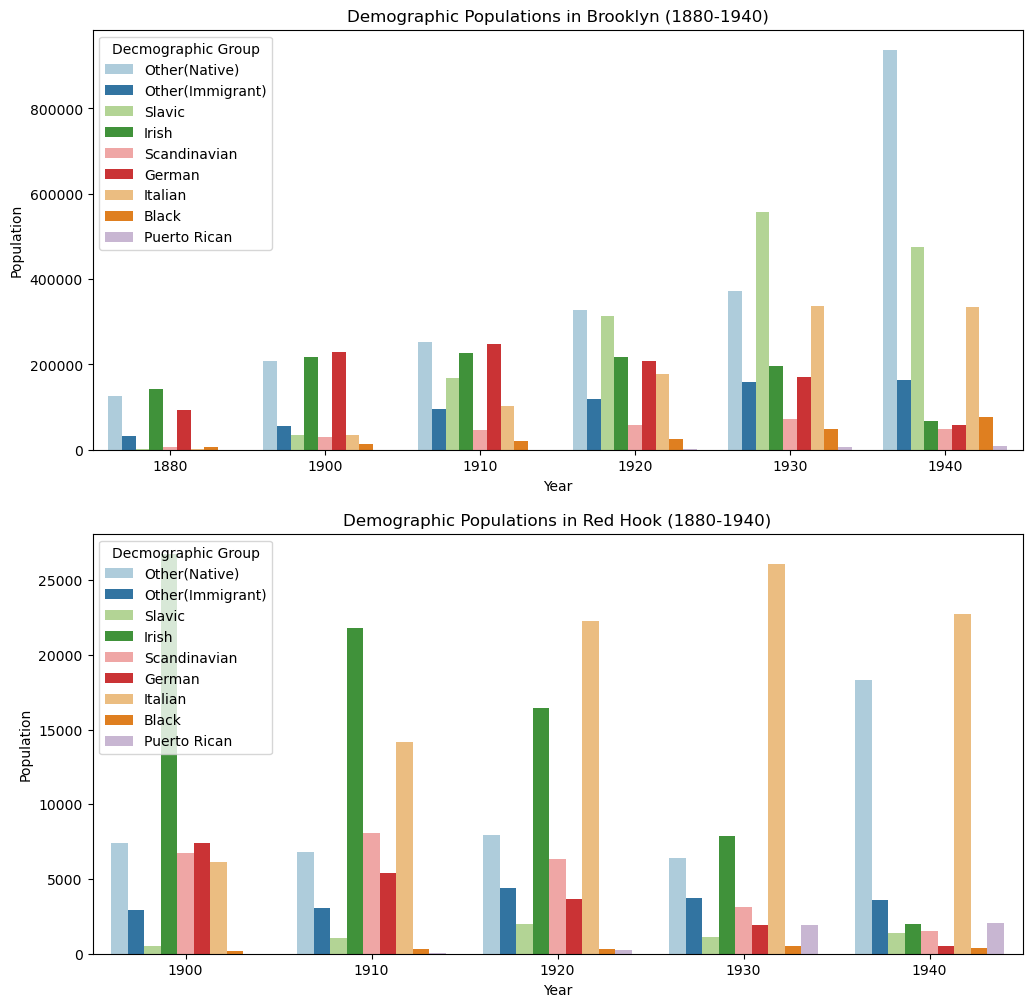

In [32]:
# Plot the count of waterfront jobs over the decades by race group in Brooklyn as a whole and in Red Hook
fig, axes = plt.subplots(2, 1, figsize=(12, 12))

sns.countplot(data=df, x='YEAR', hue='DEMO_GROUP', palette='Paired', ax=axes[0])
axes[0].set_title("Demographic Populations in Brooklyn (1880-1940)")
axes[0].set_xlabel("Year")
axes[0].set_ylabel("Population")
axes[0].legend(title='Decmographic Group', labels= ['Other(Native)', 'Other(Immigrant)', 'Slavic', 'Irish', 'Scandinavian', 'German', 'Italian', 'Black', 'Puerto Rican'])

sns.countplot(data=df_redhook, x='YEAR', hue='DEMO_GROUP', palette='Paired', ax=axes[1])
axes[1].set_title("Demographic Populations in Red Hook (1880-1940)")
axes[1].set_xlabel("Year")
axes[1].set_ylabel("Population")
axes[1].legend(title='Decmographic Group', labels= ['Other(Native)', 'Other(Immigrant)', 'Slavic', 'Irish', 'Scandinavian', 'German', 'Italian', 'Black', 'Puerto Rican'])
plt.show()

As we can see in Red Hook, the Irish and Italian mirror each other's increase/decrease in population, while the number of Native non-ethnic whites spikes from 1930-1940. Note the rise in Puerto Rican population in 1930 as well.

In [33]:
df.loc[df['FBPL']>499, 'FBPL'].value_counts().head(10)

FBPL
541    13945
542     7938
500     4095
534     1814
600     1465
515     1198
900      996
700      724
501      701
521      465
Name: count, dtype: int64

**Longshoremen/Stevedore Jobs Over Time**

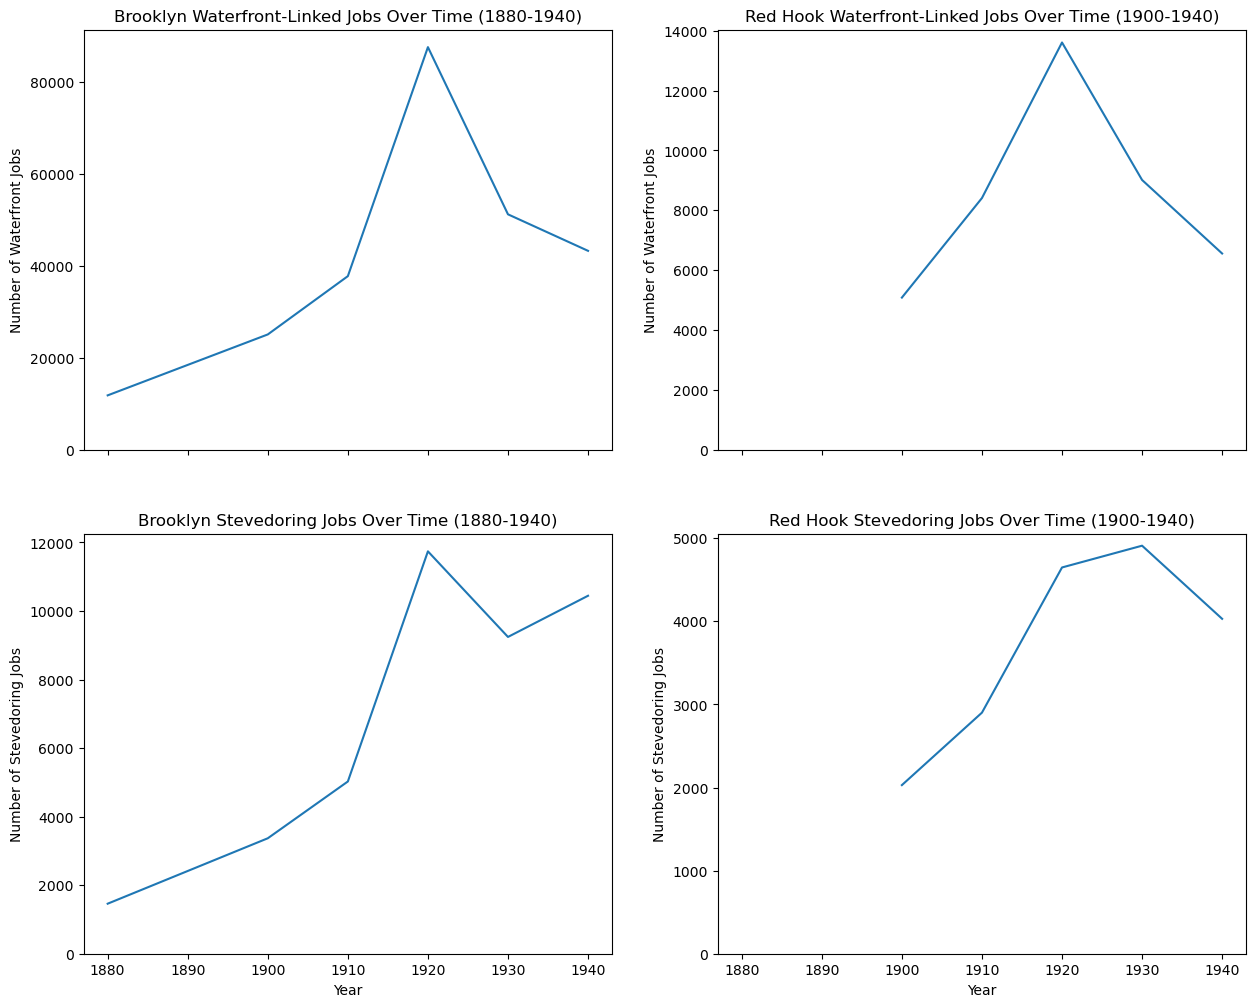

In [34]:
# Plot Stevedoring and general Waterfront Industrial Jobs Over Time in Brooklyn and Red Hook

# Data preparation
wfjob_counts = df.groupby('YEAR')['ISWATERFRONT'].sum().reset_index()
dockjob_counts = df.groupby('YEAR')['ISDOCKWORKER'].sum().reset_index()

# Create subplots with 2 rows and 1 column
fig, axes = plt.subplots(2, 2, figsize=(15, 12), sharex=True)

# Plot 1: Waterfront-Linked Jobs Over Time
sns.lineplot(data=wfjob_counts, x='YEAR', y='ISWATERFRONT', ax=axes[0, 0])
axes[0, 0].set_title("Brooklyn Waterfront-Linked Jobs Over Time (1880-1940)")
axes[0, 0].set_xlabel("Year")
axes[0, 0].set_ylabel("Number of Waterfront Jobs")
axes[0, 0].set_ylim(ymin=0)

# Plot 2: Stevedoring Jobs Over Time
sns.lineplot(data=dockjob_counts, x='YEAR', y='ISDOCKWORKER', ax=axes[1, 0])
axes[1, 0].set_title("Brooklyn Stevedoring Jobs Over Time (1880-1940)")
axes[1, 0].set_xlabel("Year")
axes[1, 0].set_ylabel("Number of Stevedoring Jobs")
axes[1, 0].set_ylim(ymin=0)


# Now For the Red Hook Plots
rhwf_counts = df_redhook.groupby('YEAR')['ISWATERFRONT'].sum().reset_index()
rhdock_counts = df_redhook.groupby('YEAR')['ISDOCKWORKER'].sum().reset_index()

# Plot 3: Waterfront jobs in Red Hook
sns.lineplot(data=rhwf_counts, x='YEAR', y='ISWATERFRONT', ax=axes[0, 1])
axes[0, 1].set_title("Red Hook Waterfront-Linked Jobs Over Time (1900-1940)")
axes[0, 1].set_xlabel("Year")
axes[0, 1].set_ylabel("Number of Waterfront Jobs")
axes[0, 1].set_ylim(ymin=0)

# Finally, stevedoring jobs in red hook
sns.lineplot(data=rhdock_counts, x='YEAR', y='ISDOCKWORKER', ax=axes[1, 1])
axes[1, 1].set_title("Red Hook Stevedoring Jobs Over Time (1900-1940)")
axes[1, 1].set_xlabel("Year")
axes[1, 1].set_ylabel("Number of Stevedoring Jobs")
axes[1, 1].set_ylim(ymin=0)

# Show the plots
plt.show()

**Dockworkers Over Time by Demographic;**

Brooklyn and Red Hook

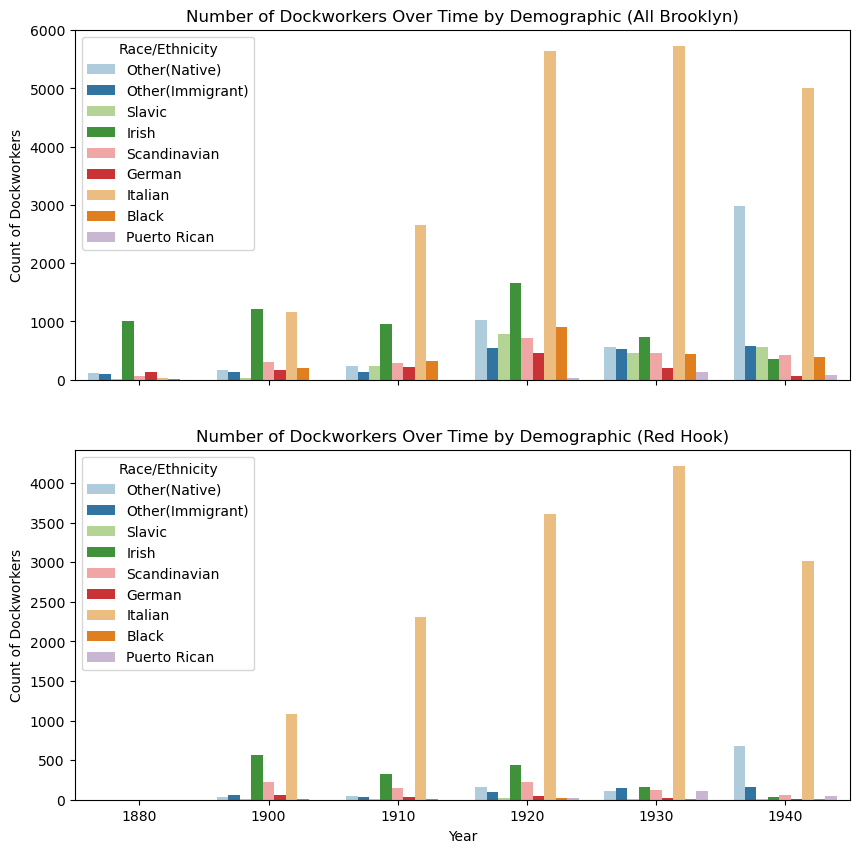

In [35]:
df_dock = df[df['ISDOCKWORKER']]
df_redhookdock = df_redhook[df_redhook['ISDOCKWORKER']]
# isolate just Stevedoring Population

fig, axes = plt.subplots(2, 1, figsize=(10, 10), sharex=True)

sns.countplot(data=df_dock, x='YEAR', hue='DEMO_GROUP', palette='Paired', ax=axes[0])
axes[0].set_title("Number of Dockworkers Over Time by Demographic (All Brooklyn)")
axes[0].set_xlabel("Year")
axes[0].set_ylabel("Count of Dockworkers")
axes[0].legend(title='Race/Ethnicity', labels= ['Other(Native)', 'Other(Immigrant)', 'Slavic', 'Irish', 'Scandinavian', 'German', 'Italian', 'Black', 'Puerto Rican'])

sns.countplot(data=df_redhookdock, x='YEAR', hue='DEMO_GROUP', palette='Paired', ax=axes[1])
axes[1].set_title("Number of Dockworkers Over Time by Demographic (Red Hook)")
axes[1].set_xlabel("Year")
axes[1].set_ylabel("Count of Dockworkers")
axes[1].legend(title='Race/Ethnicity', labels= ['Other(Native)', 'Other(Immigrant)', 'Slavic', 'Irish', 'Scandinavian', 'German', 'Italian', 'Black', 'Puerto Rican'])



plt.show()

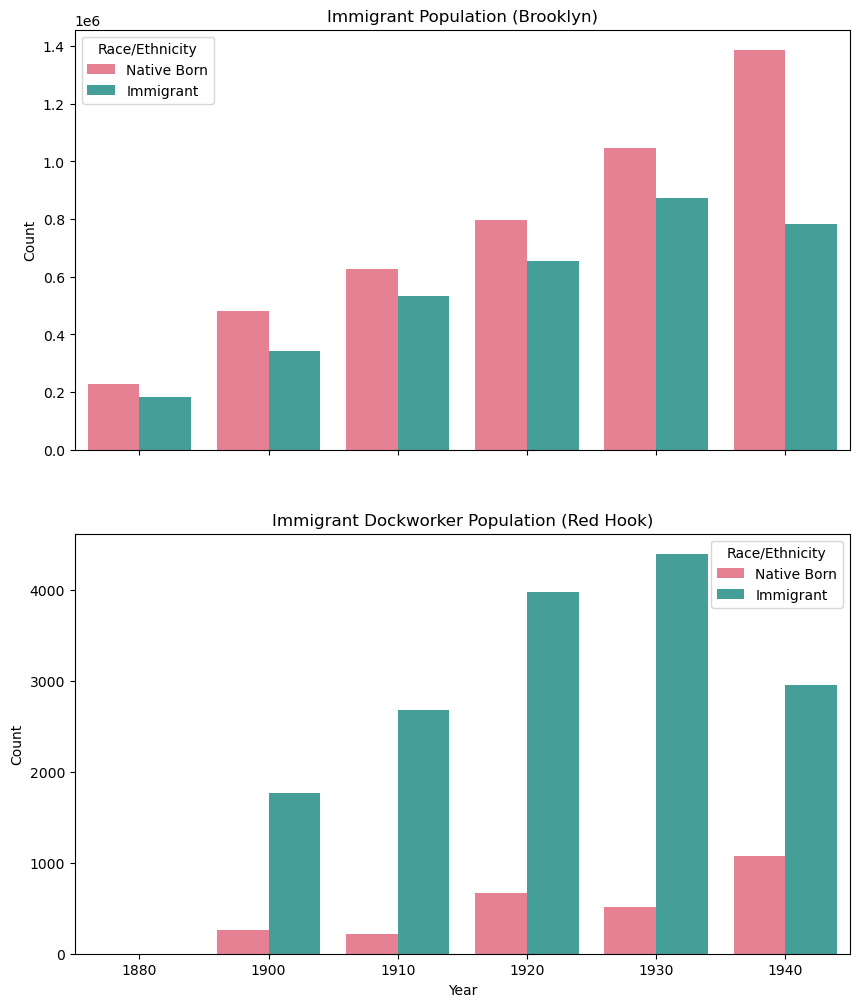

In [36]:
fig, axes = plt.subplots(2, 1, figsize=(10, 12), sharex=True)

sns.countplot(data=df, x='YEAR', hue='ISIMMIGRANT', palette='husl', ax=axes[0])
axes[0].set_title("Immigrant Population (Brooklyn)")
axes[0].set_xlabel("Year")
axes[0].set_ylabel("Count")

axes[0].legend(title='Race/Ethnicity', labels= ['Native Born', 'Immigrant'])


sns.countplot(data=df_redhook[df_redhook['ISDOCKWORKER']], x='YEAR', hue='ISIMMIGRANT', palette='husl', ax=axes[1])
axes[1].set_title("Immigrant Dockworker Population (Red Hook)")
axes[1].set_xlabel("Year")
axes[1].set_ylabel("Count")

axes[1].legend(title='Race/Ethnicity', labels= ['Native Born', 'Immigrant'])

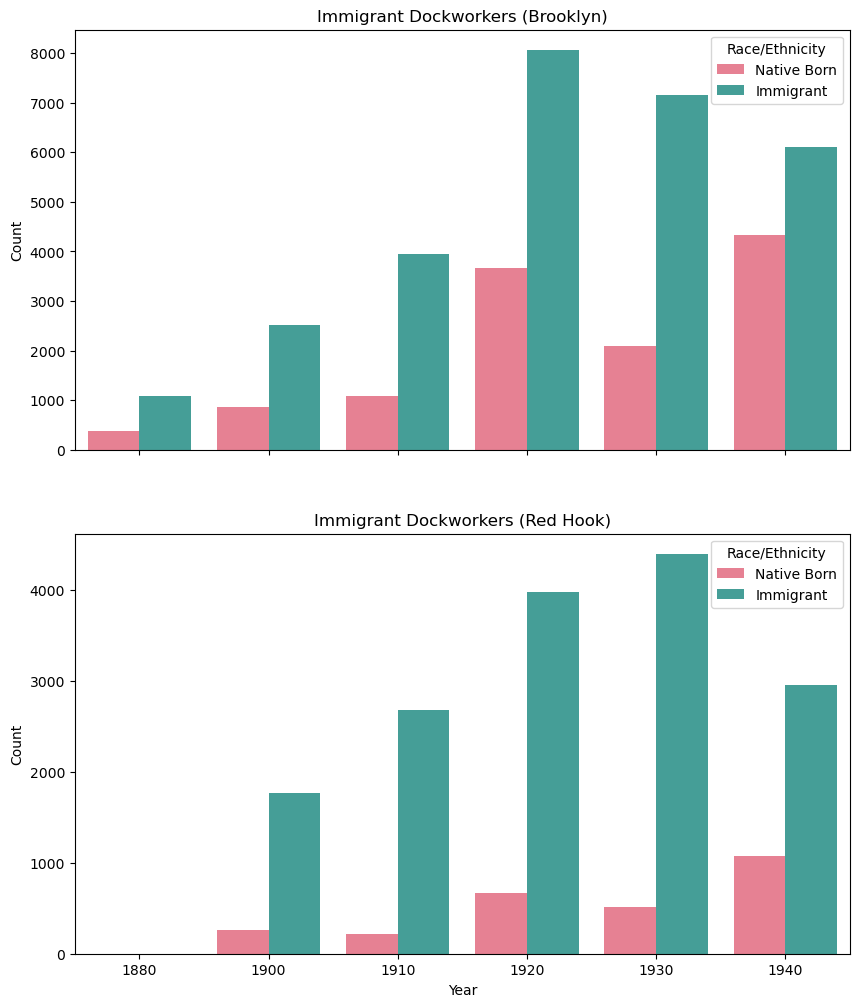

In [37]:

fig, axes = plt.subplots(2, 1, figsize=(10, 12), sharex=True)

sns.countplot(data=df_dock, x='YEAR', hue='ISIMMIGRANT', palette='husl', ax=axes[0])
axes[0].set_title("Immigrant Dockworkers (Brooklyn)")
axes[0].set_xlabel("Year")
axes[0].set_ylabel("Count")

axes[0].legend(title='Race/Ethnicity', labels= ['Native Born', 'Immigrant'])


sns.countplot(data=df_redhookdock, x='YEAR', hue='ISIMMIGRANT', palette='husl', ax=axes[1])
axes[1].set_title("Immigrant Dockworkers (Red Hook)")
axes[1].set_xlabel("Year")
axes[1].set_ylabel("Count")

axes[1].legend(title='Race/Ethnicity', labels= ['Native Born', 'Immigrant'])


plt.show()

What is the explanation for this jarring shift? It must be a data issue.

**Immigrant Longshoremen by Demographic**

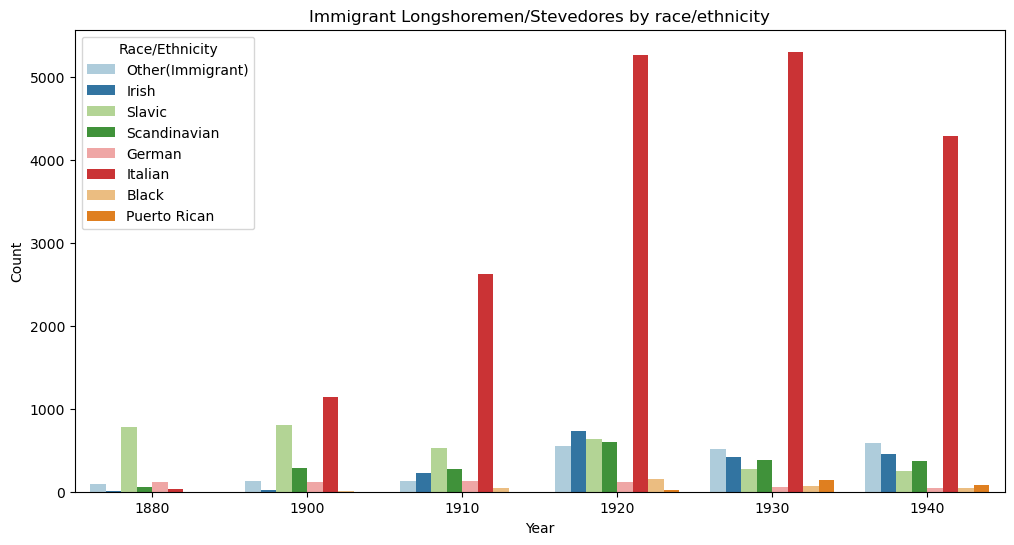

In [38]:
df_immdock = df[(df['ISIMMIGRANT'])&(df['ISDOCKWORKER'])]
# isolate just Stevedoring Population

plt.figure(figsize=(12, 6))
sns.countplot(data=df_immdock, x='YEAR', hue='DEMO_GROUP', palette='Paired')
plt.title("Immigrant Longshoremen/Stevedores by race/ethnicity")
plt.xlabel("Year")
plt.ylabel("Count")

plt.legend(title='Race/Ethnicity', labels= ['Other(Immigrant)', 'Irish', 'Slavic', 'Scandinavian', 'German', 'Italian', 'Black', 'Puerto Rican'])

plt.show()

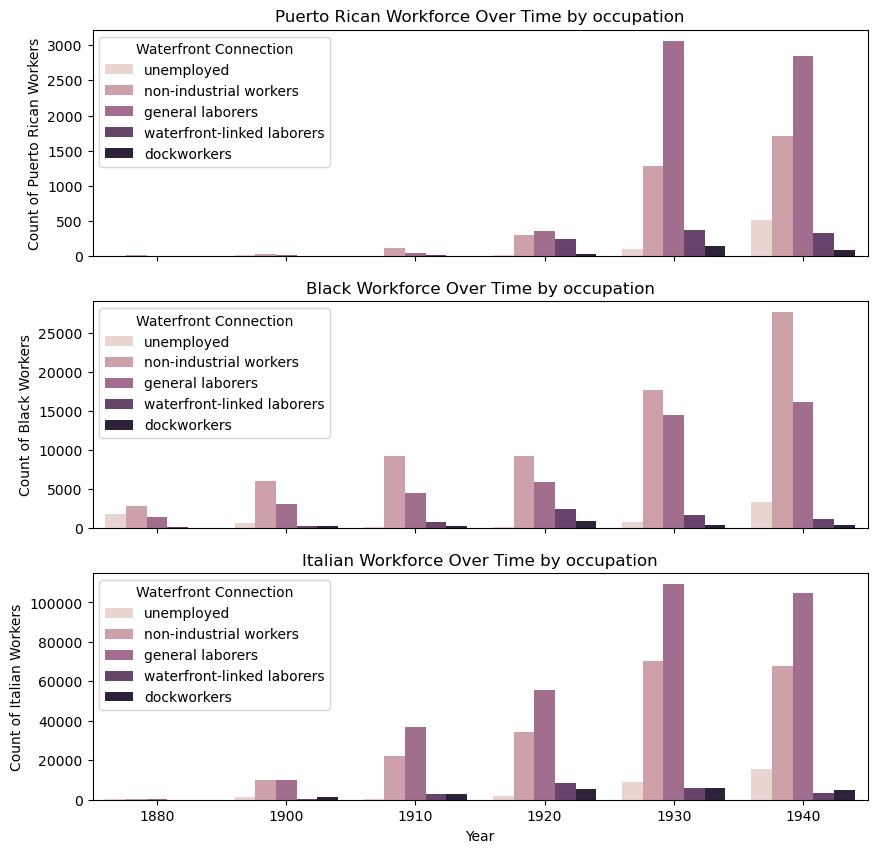

In [39]:
# plot Puerto Rican, Black, and Italian employment categories (waterfront relevant) over time IN BROOKLYN
fig, axes = plt.subplots(3, 1, sharex=True, figsize=(10, 10))

df_jobrecorded = drop_unrecorded_jobs(df)

df_pr = df_jobrecorded[df_jobrecorded['ISPR']]
df_it = df_jobrecorded[df_jobrecorded['ISITALIAN']]
df_blk = df_jobrecorded[df_jobrecorded['ISBLACK']]


sns.countplot(data=df_pr, x='YEAR', hue='JOB_GROUP', ax=axes[0])
axes[0].set_title("Puerto Rican Workforce Over Time by occupation")
axes[0].set_xlabel("Year")
axes[0].set_ylabel("Count of Puerto Rican Workers")
axes[0].legend(title='Waterfront Connection', labels=['unemployed', 'non-industrial workers', 'general laborers', 'waterfront-linked laborers', 'dockworkers'])


sns.countplot(data=df_blk, x='YEAR', hue='JOB_GROUP', ax=axes[1])
axes[1].set_title("Black Workforce Over Time by occupation")
axes[1].set_xlabel("Year")
axes[1].set_ylabel("Count of Black Workers")
axes[1].legend(title='Waterfront Connection', labels=['unemployed', 'non-industrial workers', 'general laborers', 'waterfront-linked laborers', 'dockworkers'])

sns.countplot(data=df_it, x='YEAR', hue='JOB_GROUP', ax=axes[2])
axes[2].set_title("Italian Workforce Over Time by occupation")
axes[2].set_xlabel("Year")
axes[2].set_ylabel("Count of Italian Workers")
axes[2].legend(title='Waterfront Connection', labels=['unemployed', 'non-industrial workers', 'general laborers', 'waterfront-linked laborers', 'dockworkers'])

plt.show()


Now let's look at the same thing in Red Hook

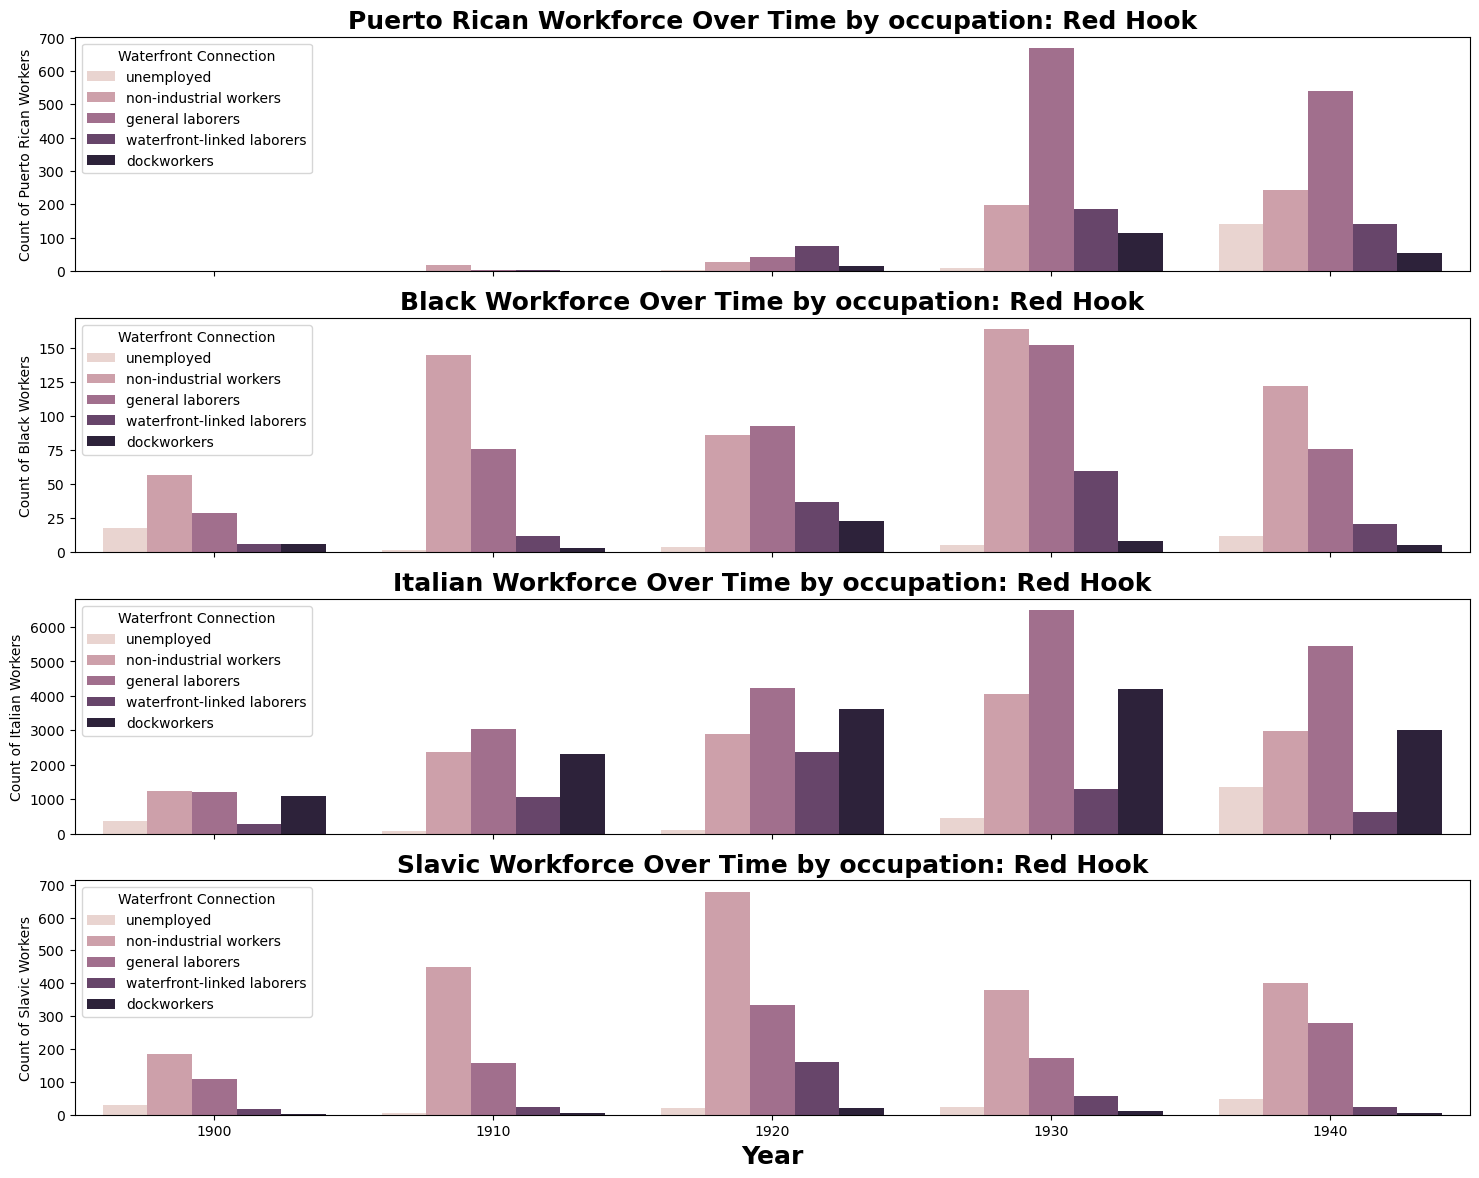

In [40]:
# plot Puerto Rican, Black, and Italian employment categories (waterfront relevant) over time IN RED HOOK
fig, axes = plt.subplots(4, 1, sharex=True, figsize=(18, 14))

dfrh_jobrecorded = drop_unrecorded_jobs(df_redhook)

dfrh_pr = dfrh_jobrecorded[dfrh_jobrecorded['ISPR']]
dfrh_it = dfrh_jobrecorded[dfrh_jobrecorded['ISITALIAN']]
dfrh_blk = dfrh_jobrecorded[dfrh_jobrecorded['ISBLACK']]
dfrh_sv = dfrh_jobrecorded[dfrh_jobrecorded['ISSLAVIC']]


sns.countplot(data=dfrh_pr, x='YEAR', hue='JOB_GROUP', ax=axes[0])
axes[0].set_title("Puerto Rican Workforce Over Time by occupation: Red Hook", fontsize=18, weight='bold')
axes[0].set_xlabel("Year")
axes[0].set_ylabel("Count of Puerto Rican Workers")
axes[0].legend(title='Waterfront Connection', labels=['unemployed', 'non-industrial workers', 'general laborers', 'waterfront-linked laborers', 'dockworkers'])


sns.countplot(data=dfrh_blk, x='YEAR', hue='JOB_GROUP', ax=axes[1])
axes[1].set_title("Black Workforce Over Time by occupation: Red Hook", fontsize=18, weight='bold')
axes[1].set_xlabel("Year")
axes[1].set_ylabel("Count of Black Workers")
axes[1].legend(title='Waterfront Connection', labels=['unemployed', 'non-industrial workers', 'general laborers', 'waterfront-linked laborers', 'dockworkers'])

sns.countplot(data=dfrh_it, x='YEAR', hue='JOB_GROUP', ax=axes[2])
axes[2].set_title("Italian Workforce Over Time by occupation: Red Hook", fontsize=18, weight='bold')
axes[2].set_xlabel("Year", fontsize=18, weight='bold')
axes[2].set_ylabel("Count of Italian Workers")
axes[2].legend(title='Waterfront Connection', labels=['unemployed', 'non-industrial workers', 'general laborers', 'waterfront-linked laborers', 'dockworkers'])

sns.countplot(data=dfrh_sv, x='YEAR', hue='JOB_GROUP', ax=axes[3])
axes[3].set_title("Slavic Workforce Over Time by occupation: Red Hook", fontsize=18, weight='bold')
axes[3].set_xlabel("Year", fontsize=18, weight='bold')
axes[3].set_ylabel("Count of Slavic Workers")
axes[3].legend(title='Waterfront Connection', labels=['unemployed', 'non-industrial workers', 'general laborers', 'waterfront-linked laborers', 'dockworkers'])

plt.show()

Fascinating! There is so much to take away from this data. 

Text(0.5, 1.0, 'Most Common Puerto Rican Occupation Codes')

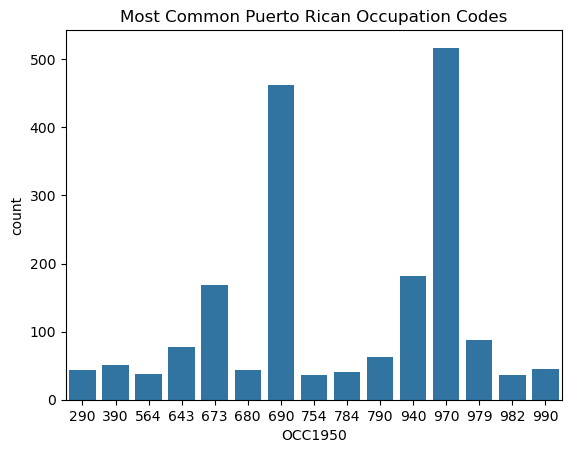

In [41]:
sns.barplot(data=df_redhook.loc[(df_redhook['ISPR'])&(df_redhook['OCC_UNKNOWN']==False), 'OCC1950'].value_counts().head(15))
plt.title('Most Common Puerto Rican Occupation Codes')

690 and 970 both being the catch-all codes for their respective categories (Operatives and Laborers) suggests a more day-laborer role of these workers, although there really is no way of telling completely. Seeing as there is a designated code for Dockworkers which is by no means generally ignored, there is little reason to believe that many of these laborers work on the docks, unless the way they were recorded differs from other workers. There is no reason to speculate, though, so we will accept these codes at face value.

940: Longshoremen/Stevedores
673: Sailors and Deck Hands
- This code is incredibly interesting, and according to the alphabetic guidebook, really only applies to people on the ships themselves. Was there a serious population of Puerto Rican sailors, deck hands, or ferrymen living in Brooklyn? None of my other sources suggest this, but this history is not very documented, so it is definitely possible.

Text(0.5, 1.0, 'Most Common Puerto Rican Industry Codes')

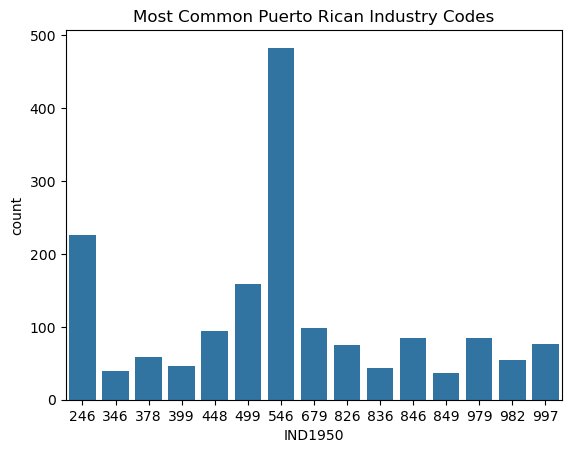

In [42]:
sns.barplot(data=df_redhook.loc[(df_redhook['ISPR'])&(df_redhook['IND1950']!=0), 'IND1950'].value_counts().head(15))
plt.title('Most Common Puerto Rican Industry Codes')

Some codes to note:
246: Construction
546: Water Transportation
446: Manufacturing - Apparel and accessories
499: Not Specified Manufacturing

679 and above are service industry jobs

In terms of industrial labor, Construction, Manufactruring, and "Water Transportation" ostensibly maritime industry, dominates.

Finally, let's make a heatmap of that percentage dataframe we made earlier. It still isn't the perfect way of visualizing the imbalances, and I may need to refine my categorization a bit more, but it's a step in the right direction.

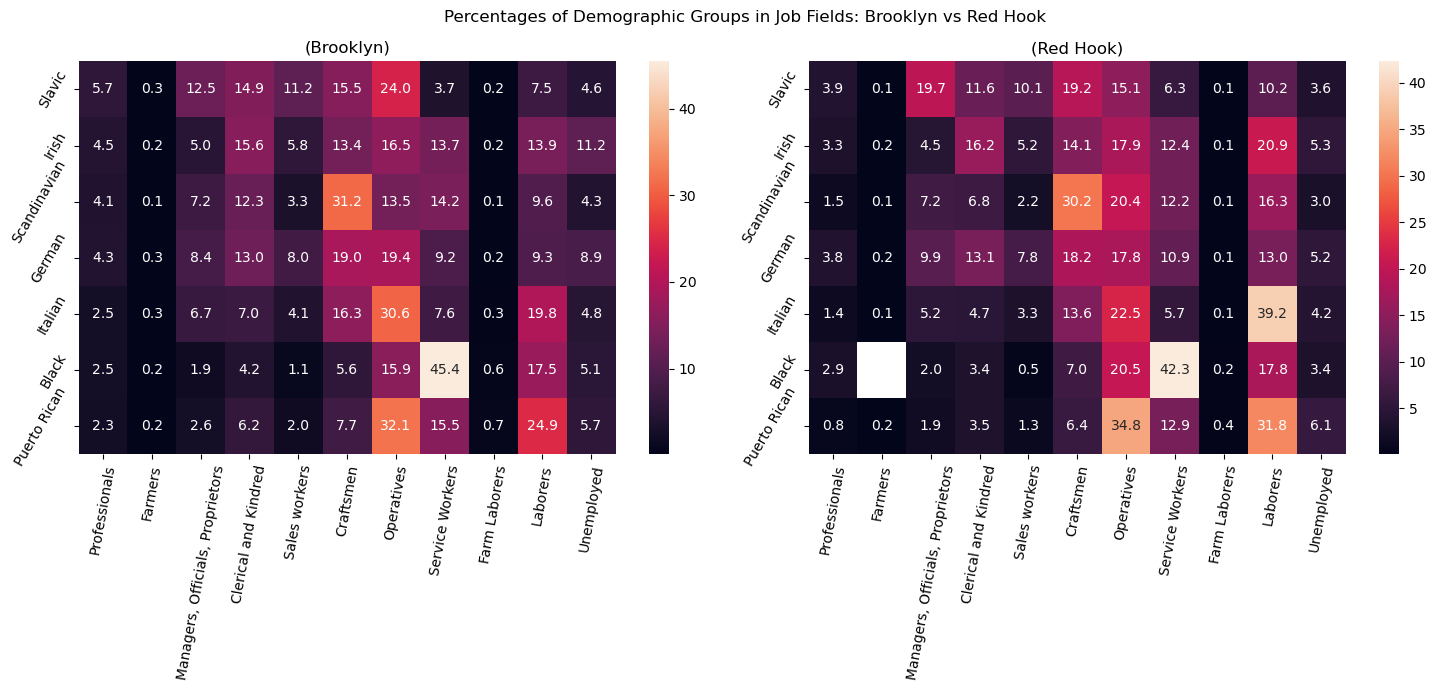

In [43]:
# Create the pivot table
def pivotdf(df):
    dfcounts = reduce_demographic(drop_unrecorded_jobs(df)).groupby(['DEMO_GROUP', 'OCC_CATEGORY']).size().reset_index().pivot_table(values=0,columns='OCC_CATEGORY',index=['DEMO_GROUP'])

    dfcounts.columns = dfcounts.columns.get_level_values(0)

    # Rename the columns to descriptive names
    dfcounts = dfcounts.rename(columns={
        0: 'Professionals', 
        1: 'Farmers', 
        2: 'Managers, Officials, Proprietors', 
        3: 'Clerical and Kindred',  
        4: 'Sales workers',
        5: 'Craftsmen',
        6: 'Operatives',
        7: 'Service Workers',
        8: 'Farm Laborers',
        9: 'Laborers',
        10: 'Unemployed'
        },
                           index={2: 'Slavic', 3: 'Irish', 4: 'Scandinavian',  5: 'German', 6: 'Italian', 7: 'Black', 8: 'Puerto Rican'})

    # We can also make the same dataframe display the percentages of each demographic group population in each labor category
    dfpercentages = dfcounts.div(dfcounts.sum(axis=1), axis=0) * 100
    
    return dfcounts, dfpercentages


bkpivot, bkpercentages = pivotdf(df)

rhpivot, rhpercentages = pivotdf(df_redhook)


# Now we can graph this dataframe for a heatmap

fig, axes = plt.subplots(1, 2, figsize=(15, 7))
fig.suptitle("Percentages of Demographic Groups in Job Fields: Brooklyn vs Red Hook")

sns.heatmap(bkpercentages, annot=True, fmt=".1f", ax=axes[0])
axes[0].set_title("(Brooklyn)")
axes[0].set_xlabel('')
axes[0].set_ylabel('')
axes[0].tick_params(axis='x', rotation=80)
axes[0].tick_params(axis='y', rotation=60)


sns.heatmap(rhpercentages, annot=True, fmt=".1f", ax=axes[1])
axes[1].set_title("(Red Hook)")
axes[1].set_xlabel('')
axes[1].set_ylabel('')
axes[1].tick_params(axis='x', rotation=80)
axes[1].tick_params(axis='y', rotation=60)

plt.tight_layout()

plt.show()

# Interesting to see how, in Brooklyn, a much larger share of Italians are Longshoremen, while Black and Puerto Rican workers are disporportionately funnelled to more basic labor occupations

This result is very interesting, indicating a clear funnelling of Black workers into service jobs, and Italians, Irish and Puerto Ricans into Laborer Jobs. In Red Hook specifically, it's interesting to note that more Italians are designated as "Laborers" while more Puerto Ricans are "operatives".

It's also clear that German, Slavic, and even Irish populations are more likely to hold clerical and manegerial, and artisan jobs, which are likely higher paying.

It should be noted that there is some muddy overlap and discrepancy between/among the "Operative" and "Laborer" occupation classification: It is sometimes hard to tell what "Operative" Jobs are more more technical jobs, and which are more general factory machinery jobs.

#### Spatial Plotting
Much more to come in terms of spatial plotting.

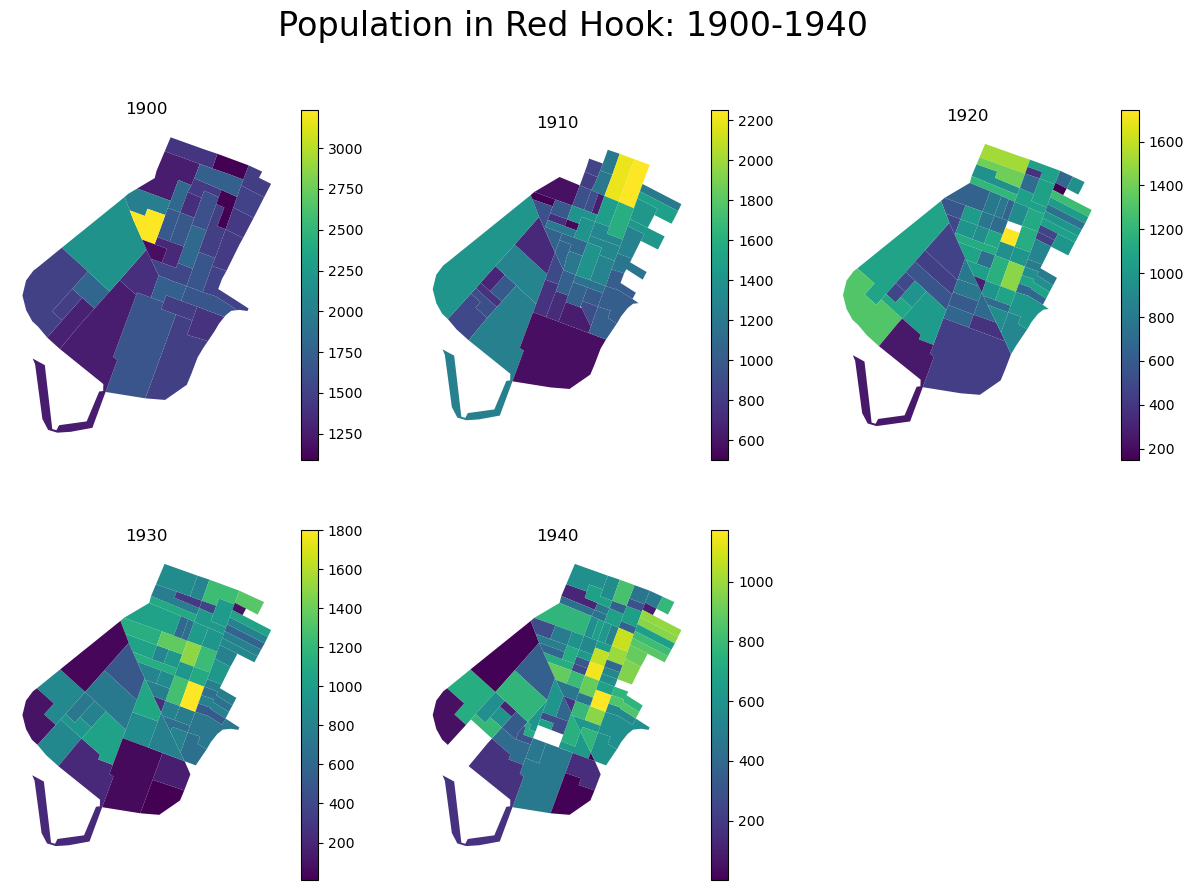

In [44]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

gdf_1900.plot(column='TOTAL_POP', ax=axes[0, 0], legend=True).set_axis_off()
gdf_1910.plot(column='TOTAL_POP', ax=axes[0, 1], legend=True).set_axis_off()
gdf_1920.plot(column='TOTAL_POP', ax=axes[0, 2], legend=True).set_axis_off()
gdf_1930.plot(column='TOTAL_POP', ax=axes[1, 0], legend=True).set_axis_off()
gdf_1940.plot(column='TOTAL_POP', ax=axes[1, 1], legend=True).set_axis_off()

axes[0, 0].set_title('1900')
axes[0, 1].set_title('1910')
axes[0, 2].set_title('1920')
axes[1, 0].set_title('1930')
axes[1, 1].set_title('1940')
axes[1, 2].set_axis_off()

fig.suptitle('Population in Red Hook: 1900-1940', fontsize=24)


plt.show()

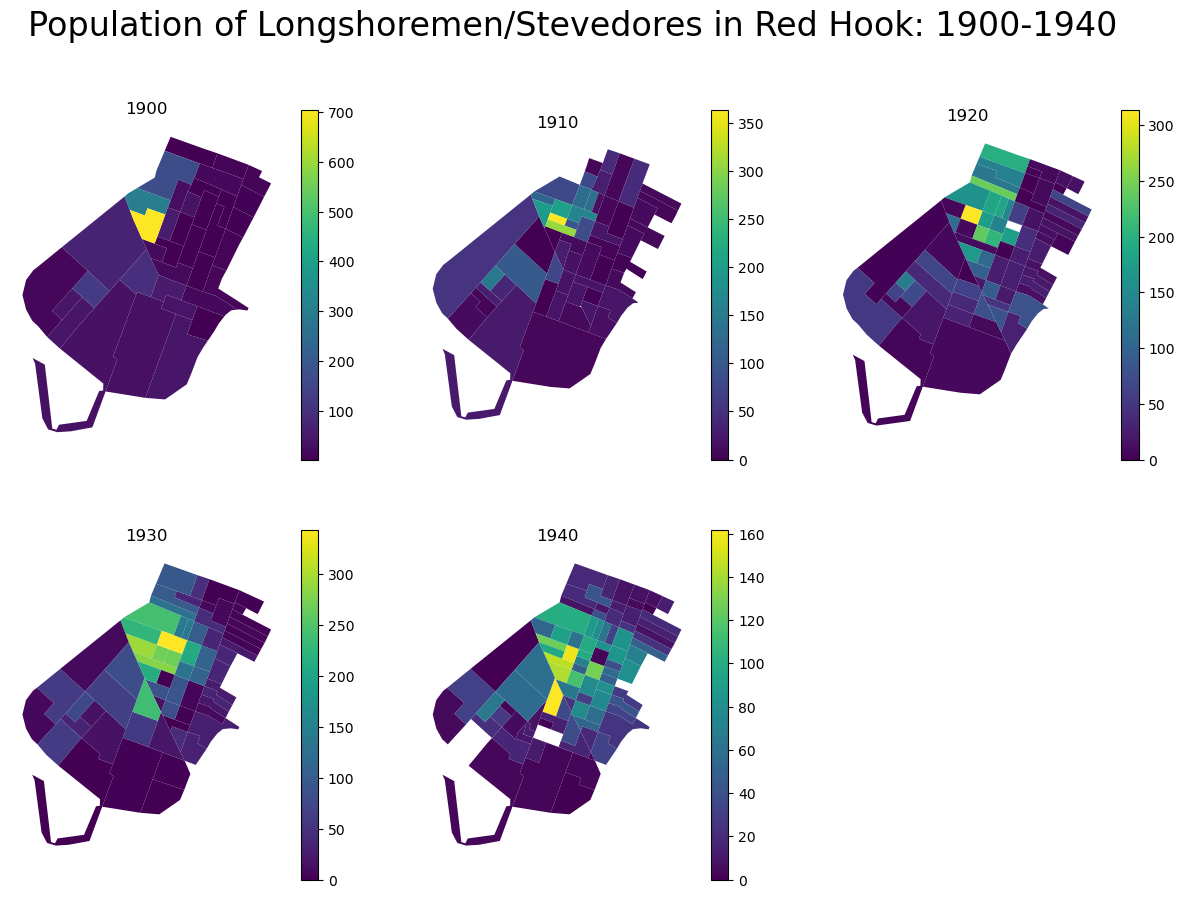

In [45]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

gdf_1900.plot(column='ISDOCKWORKER', ax=axes[0, 0], legend=True).set_axis_off()
gdf_1910.plot(column='ISDOCKWORKER', ax=axes[0, 1], legend=True).set_axis_off()
gdf_1920.plot(column='ISDOCKWORKER', ax=axes[0, 2], legend=True).set_axis_off()
gdf_1930.plot(column='ISDOCKWORKER', ax=axes[1, 0], legend=True).set_axis_off()
gdf_1940.plot(column='ISDOCKWORKER', ax=axes[1, 1], legend=True).set_axis_off()

axes[0, 0].set_title('1900')
axes[0, 1].set_title('1910')
axes[0, 2].set_title('1920')
axes[1, 0].set_title('1930')
axes[1, 1].set_title('1940')
axes[1, 2].set_axis_off()

fig.suptitle('Population of Longshoremen/Stevedores in Red Hook: 1900-1940', fontsize=24)


plt.show()

## 3. Modeling
We are going to do a Classification modeling to predict employment information of a census-taker based on a variety of other boolean categories, such as if they are Irish, Italian Puerto Rican, Black, German, or Slavic, their and their parents' immigrant status, as well as whether or not they live in Group Quarters.

### Train-Test Split
Since we are going to run our moedls on each decade's census, we make our train-test split a function that can work on any of these censuses.

In [46]:
np.array(df_1900_redhook.columns)

array(['YEAR', 'SAMPLE', 'SERIAL', 'HHWT', 'STATEFIP', 'COUNTYICP', 'GQ',
       '1900label', 'PERNUM', 'SEX', 'AGE', 'RACE', 'RACED', 'HISPAN',
       'HISPAND', 'BPL', 'BPLD', 'MBPL', 'MBPLD', 'FBPL', 'FBPLD',
       'NATIVITY', 'OCC1950', 'IND1950', 'VERSIONHIST', 'HISTID',
       'MBPL_MOM', 'MBPL_POP', 'MBPL_MOM2', 'MBPL_POP2', 'FBPL_MOM',
       'FBPL_POP', 'FBPL_MOM2', 'FBPL_POP2', 'ISIMMIGRANT', 'ISGENTWO',
       'ISPR', 'ISWHITE', 'ISBLACK', 'ITALYBPL', 'ISITALIAN',
       'ISWHITE_NON_ITALIAN', 'ISGERMAN', 'ISSLAVIC', 'ISIRISH',
       'ISSCANDI', 'DEMO_GROUP', 'IS_OTHER_NATIVE', 'IS_OTHER_IMMIGRANT',
       'UNEMPLOYED', 'OCC_UNKNOWN', 'OCC_CATEGORY', 'OCC_PRO/TECH',
       'OCC_FARM', 'OCC_MAN/OFF/PROP', 'OCC_CLERICAL', 'OCC_SALES',
       'OCC_CRAFTS', 'OCC_OP', 'OCC_SERVICE', 'OCC_FARMLAB', 'OCC_LAB',
       'ISDOCKWORKER', 'ISWATERFRONT', 'ISINDUSTRY', 'JOB_GROUP', 'ISGQ',
       'ISPR_AND_UNEMPLOYED', 'ISPR_AND_OCC_UNKNOWN',
       'ISPR_AND_OCC_PRO/TECH', 'ISPR_AND_OC

In [47]:
from sklearn.model_selection import train_test_split

x_columns = ['ISPR', 'ISBLACK', 'ITALYBPL', 'ISITALIAN', 'ISGERMAN', 'ISSCANDI','ISSLAVIC', 'ISIRISH', 'IS_OTHER_NATIVE', 'IS_OTHER_IMMIGRANT', 'ISGQ', 'ISIMMIGRANT', 'ISGENTWO']
y_column = ['ISDOCKWORKER']

# This is an optional optional way to make the train/test Dataframe such that 
# half of the sample are dockworkers to prevent the model from simply picking 0 every time.
def raisedockproportion(df):
    dfdock = df[df['ISDOCKWORKER']]
    df_nodock = df[df['ISDOCKWORKER']==0]
    return pd.concat((dfdock, df_nodock.sample(n=len(dfdock))), ignore_index=True)

# Train-Test Split
def tts(df, name):
    print(f'train_test_split on {name}')
    
    # df_job_vs_demo = reduce_demographic(drop_unrecorded_jobs(df))[x_columns + y_column]
    df_job_vs_demo = drop_unrecorded_jobs(df)[x_columns + y_column]


    # Features (boolean columns)
    x = df_job_vs_demo[x_columns]

    # Target (Whether or not their work is connected to the waterfront)
    y = df_job_vs_demo[y_column]

    # Perform the Split
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

    return x_train, x_test, y_train, y_test, name


### Model 1: Logistic Regression
Our first model will be a simple logistic regression, 

In [48]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix


In [49]:
lr = LogisticRegression(max_iter=10000)

In [50]:
coefs = []

def lr_fit_predict(x_train, x_test, y_train, y_test, name):
    print(f'Logistic Regression on {name}')

    lr.fit(x_train, y_train)

    lr_pred = lr.predict(x_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, lr_pred)
    print(f'Accuracy: {accuracy} \n --------- \n')

    # confusion matrix
    cm = confusion_matrix(y_test, lr_pred)
    dfcm = pd.DataFrame(cm)
    print(f'confusion matrix: \n{dfcm} \n ---------')

    # classification report
    cr = classification_report(y_test, lr_pred)
    print(cr)
    print('\n -------------------- \n')

    coef = lr.coef_[0]
    print(coef)
    coefs.append(coef)
    plt.figure(figsize=(8,4))
    plt.barh(x_columns, coef)
    plt.title(name)
    plt.show()

train_test_split on df_1900_redhook
Logistic Regression on df_1900_redhook
Accuracy: 0.9469350411710887 
 --------- 

confusion matrix: 
      0  1
0  7245  0
1   406  0 
 ---------
              precision    recall  f1-score   support

       False       0.95      1.00      0.97      7245
        True       0.00      0.00      0.00       406

    accuracy                           0.95      7651
   macro avg       0.47      0.50      0.49      7651
weighted avg       0.90      0.95      0.92      7651


 -------------------- 

[-0.01927765 -0.04135095  1.02506217  0.67764821 -1.21754729 -0.30750889
 -1.31931505 -0.14282104 -0.48678042 -0.89547899 -0.57633255  1.32832949
  0.34357591]


/opt/anaconda3/envs/data/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/envs/data/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/data/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/data/lib/python3.11/site-packages/sklearn

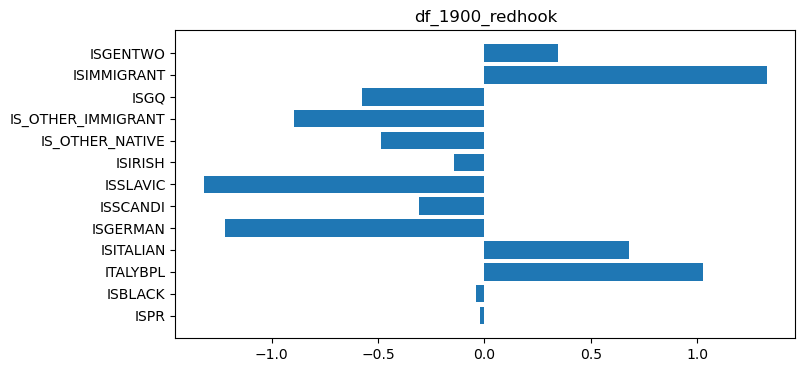

train_test_split on df_1910_redhook
Logistic Regression on df_1910_redhook
Accuracy: 0.9264705882352942 
 --------- 

confusion matrix: 
      0  1
0  7308  0
1   580  0 
 ---------
              precision    recall  f1-score   support

       False       0.93      1.00      0.96      7308
        True       0.00      0.00      0.00       580

    accuracy                           0.93      7888
   macro avg       0.46      0.50      0.48      7888
weighted avg       0.86      0.93      0.89      7888


 -------------------- 

[-0.19591508 -0.34050064  1.53610277  0.66453219 -0.83938856 -0.49084027
 -1.68116662  0.09450539 -0.00928438 -1.02160434  0.02990586  1.25994658
  0.40851289]


/opt/anaconda3/envs/data/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/envs/data/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/data/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/data/lib/python3.11/site-packages/sklearn

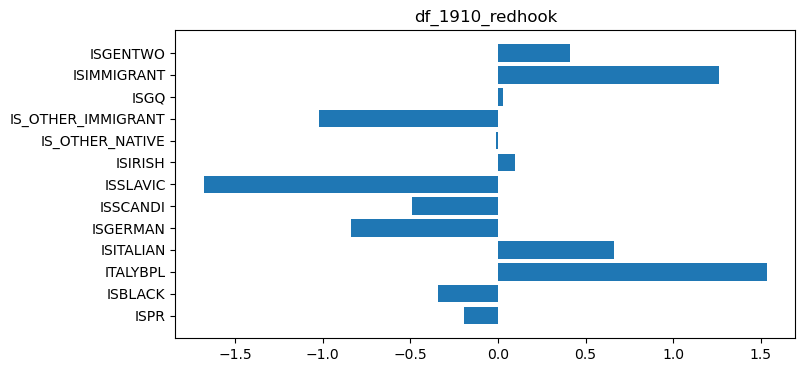

train_test_split on df_1920_redhook
Logistic Regression on df_1920_redhook
Accuracy: 0.883953082106314 
 --------- 

confusion matrix: 
      0  1
0  7084  0
1   930  0 
 ---------
              precision    recall  f1-score   support

       False       0.88      1.00      0.94      7084
        True       0.00      0.00      0.00       930

    accuracy                           0.88      8014
   macro avg       0.44      0.50      0.47      8014
weighted avg       0.78      0.88      0.83      8014


 -------------------- 

[ 0.12382403  0.46611662  1.32398907  0.42867407 -1.01293588 -0.32651183
 -1.38177497 -0.15532571 -0.13150521 -0.93996834 -0.19017178  0.69806873
  0.10110995]


/opt/anaconda3/envs/data/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/envs/data/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/data/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/data/lib/python3.11/site-packages/sklearn

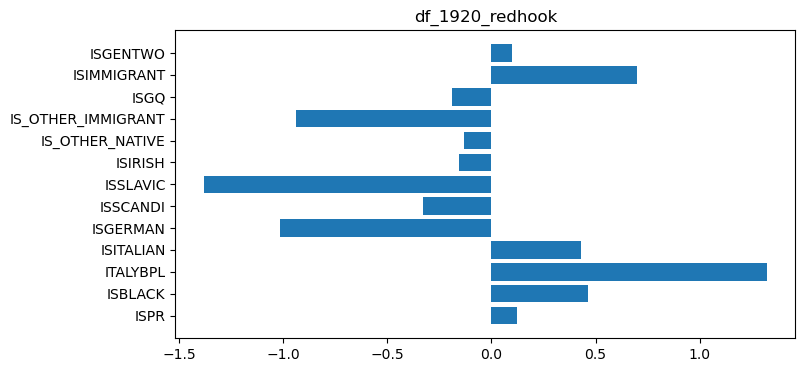

train_test_split on df_1930_redhook
Logistic Regression on df_1930_redhook
Accuracy: 0.8542594241614723 
 --------- 

confusion matrix: 
      0  1
0  5756  0
1   982  0 
 ---------
              precision    recall  f1-score   support

       False       0.85      1.00      0.92      5756
        True       0.00      0.00      0.00       982

    accuracy                           0.85      6738
   macro avg       0.43      0.50      0.46      6738
weighted avg       0.73      0.85      0.79      6738


 -------------------- 

[ 0.49254024 -0.93527102  1.93860225  0.21509445 -1.06974129 -0.0787445
 -0.95695849 -0.31801198 -0.3129114   0.02177669  0.08075069  0.47361222
  0.07508918]


/opt/anaconda3/envs/data/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/envs/data/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/data/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/data/lib/python3.11/site-packages/sklearn

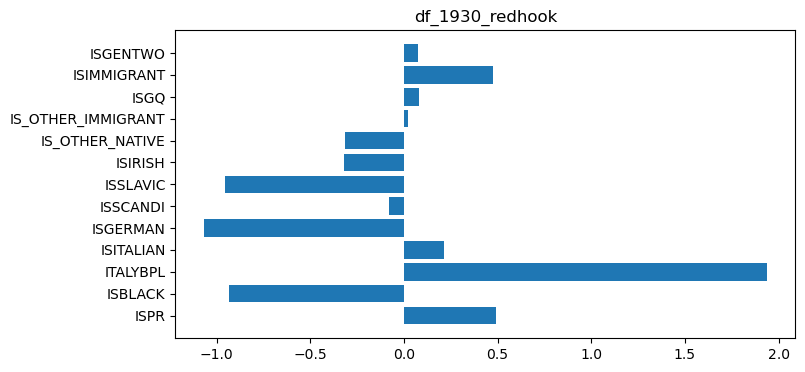

train_test_split on df_1940_redhook
Logistic Regression on df_1940_redhook
Accuracy: 0.8666887198147536 
 --------- 

confusion matrix: 
      0  1
0  5240  0
1   806  0 
 ---------
              precision    recall  f1-score   support

       False       0.87      1.00      0.93      5240
        True       0.00      0.00      0.00       806

    accuracy                           0.87      6046
   macro avg       0.43      0.50      0.46      6046
weighted avg       0.75      0.87      0.80      6046


 -------------------- 

[-0.03867641 -0.76017158  1.56277629  0.77028101 -0.86206009  0.19410208
 -1.5783549  -0.23722157 -0.00340808  0.31871176 -0.7206306  -0.34008234
 -0.89062606]


/opt/anaconda3/envs/data/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/envs/data/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/data/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/data/lib/python3.11/site-packages/sklearn

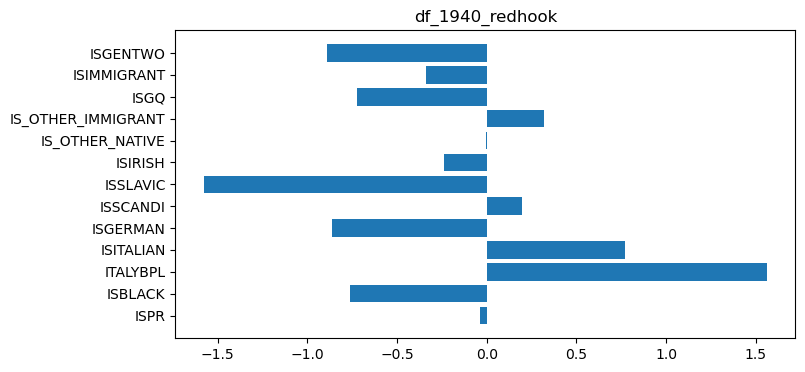

In [51]:

lr_fit_predict(*tts(df_1900_redhook, 'df_1900_redhook'))
lr_fit_predict(*tts(df_1910_redhook, 'df_1910_redhook'))
lr_fit_predict(*tts(df_1920_redhook, 'df_1920_redhook'))
lr_fit_predict(*tts(df_1930_redhook, 'df_1930_redhook'))
lr_fit_predict(*tts(df_1940_redhook, 'df_1940_redhook'))


As we can see, since work not connected with the waterfront is generally more common, the regression model often finds the highest accuracy simply guessing "no" every single time. The one exception to this is in 1920, and I am not exactly sure why this is the case. It is also difficult for us to look under the hood and see how the different variables affect probability, which makes this model not ideal.

#### Means of Coefficients

In [52]:
df_coefs = pd.DataFrame(coefs)
df_coefs.rename(columns=dict(zip(range(13), x_columns)), inplace=True)
df_coefs.mean()


ISPR                  0.072499
ISBLACK              -0.322236
ITALYBPL              1.477307
ISITALIAN             0.551246
ISGERMAN             -1.000335
ISSCANDI             -0.201901
ISSLAVIC             -1.383514
ISIRISH              -0.151775
IS_OTHER_NATIVE      -0.188778
IS_OTHER_IMMIGRANT   -0.503313
ISGQ                 -0.275296
ISIMMIGRANT           0.683975
ISGENTWO              0.007532
dtype: float64

Change in coefficients from 1900-1940

In [53]:
df_coefs.loc[4] - df_coefs.loc[0]

ISPR                 -0.019399
ISBLACK              -0.718821
ITALYBPL              0.537714
ISITALIAN             0.092633
ISGERMAN              0.355487
ISSCANDI              0.501611
ISSLAVIC             -0.259040
ISIRISH              -0.094401
IS_OTHER_NATIVE       0.483372
IS_OTHER_IMMIGRANT    1.214191
ISGQ                 -0.144298
ISIMMIGRANT          -1.668412
ISGENTWO             -1.234202
dtype: float64

### Model 2: Decision Trees
Hopefully a decision tree model will be more useful for understanding the weights of the different categories.

We will boost our decision tree classifier, and examine the weights it gives to each of our x features

In [54]:
from sklearn import tree

weak_learner = DecisionTreeClassifier(max_leaf_nodes=8)

def tree_boost_fit_predict(x_train, x_test, y_train, y_test, name):
    print(f'boosted tree classifier on {name} \n -----------')

    adaboost_clf = AdaBoostClassifier(
        estimator=weak_learner,
        n_estimators=1000,
        random_state=42
    ).fit(x_train, y_train)

    y_pred = adaboost_clf.predict(x_test)

    acc = accuracy_score(y_test, y_pred)
    print(f'Accuracy: {acc} \n -----------')

    cm = confusion_matrix(y_test, y_pred)
    print(f'Confusion Matrix: \n {cm} \n -----------')

    return adaboost_clf


In [55]:
def featureweights(abc, year):
    feature_importances = abc.feature_importances_
    print(feature_importances)
    feature_names = x_columns

    plt.figure(figsize=(10, 6))
    plt.barh(feature_names, feature_importances, color='skyblue')
    plt.xlabel("Feature Importance")
    plt.ylabel("Feature")
    plt.title(f"Feature Importance in Predicting Stevedoring Jobs: {year}")
    plt.show()

    return feature_importances

train_test_split on df_1900_redhook
boosted tree classifier on df_1900_redhook 
 -----------


/opt/anaconda3/envs/data/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/envs/data/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Accuracy: 0.9469350411710887 
 -----------
Confusion Matrix: 
 [[7245    0]
 [ 406    0]] 
 -----------
[0.13067213 0.01116751 0.00586411 0.01361759 0.0179835  0.02097484
 0.01090629 0.00409497 0.01415273 0.01724962 0.02451983 0.00566788
 0.076129  ]


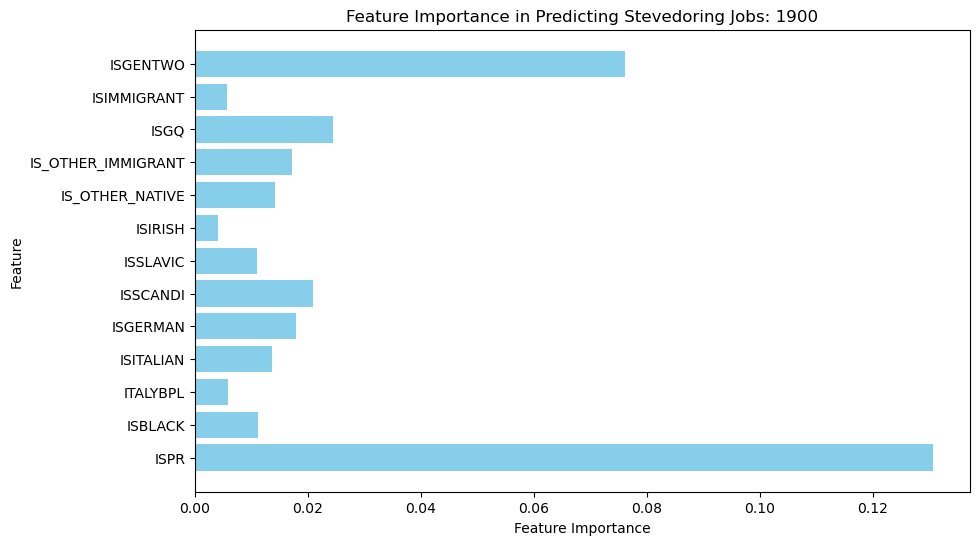

train_test_split on df_1910_redhook
boosted tree classifier on df_1910_redhook 
 -----------


/opt/anaconda3/envs/data/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/envs/data/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Accuracy: 0.9264705882352942 
 -----------
Confusion Matrix: 
 [[7308    0]
 [ 580    0]] 
 -----------
[ 0.46444344  0.02211495 -0.01105786 -0.15084571  0.05429599  0.01508938
  0.02073759  0.01047188 -0.01808798  0.02121679  0.01719695  0.01989483
  0.04152974]


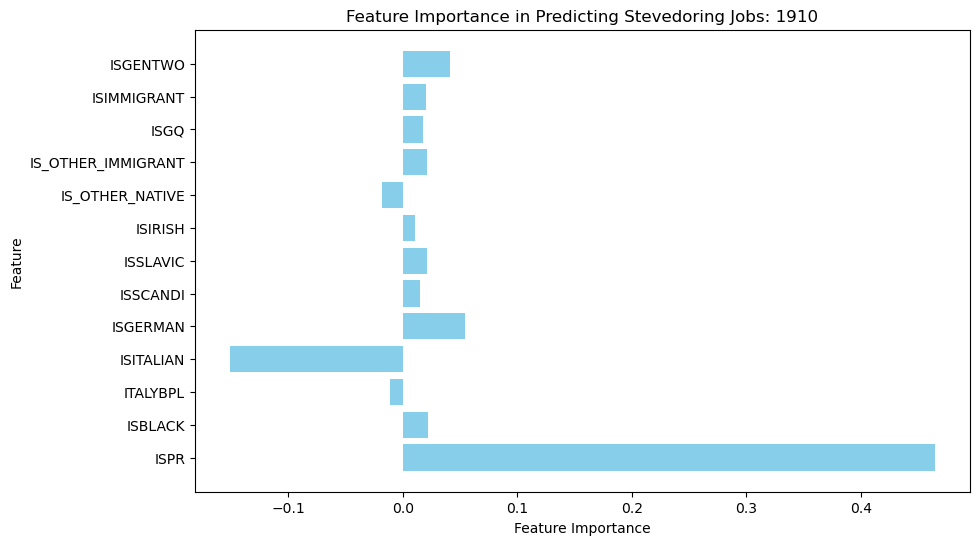

train_test_split on df_1920_redhook
boosted tree classifier on df_1920_redhook 
 -----------


/opt/anaconda3/envs/data/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/envs/data/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Accuracy: 0.883953082106314 
 -----------
Confusion Matrix: 
 [[7084    0]
 [ 930    0]] 
 -----------
[ 0.03710527  0.02073745  0.03120784  0.04686812  0.05344997  0.03791081
  0.07806941 -0.05426864  0.03072053  0.04035104  0.13133076  0.19243413
  0.1970833 ]


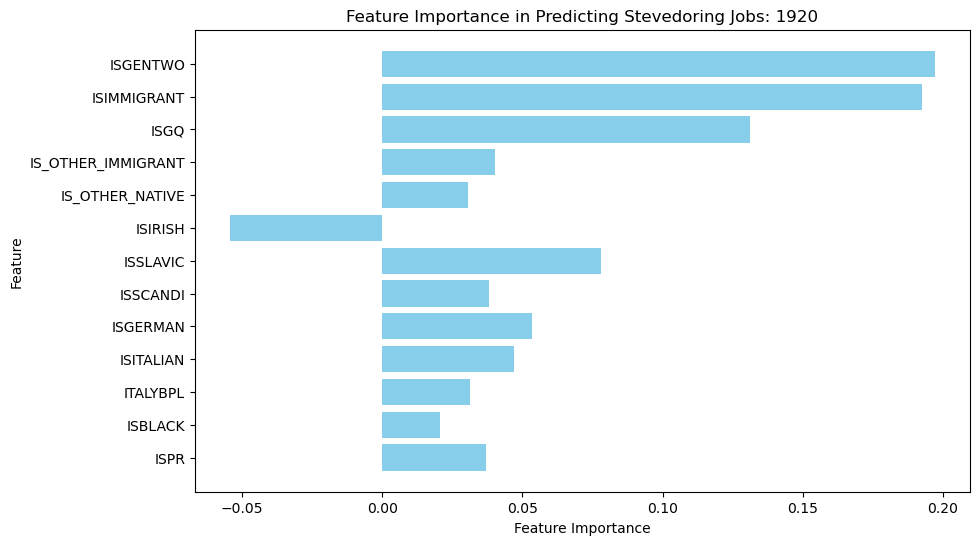

train_test_split on df_1930_redhook
boosted tree classifier on df_1930_redhook 
 -----------


/opt/anaconda3/envs/data/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/envs/data/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Accuracy: 0.8542594241614723 
 -----------
Confusion Matrix: 
 [[5749    7]
 [ 975    7]] 
 -----------
[-0.31082336  0.16720711  0.03276437  0.04236607  0.02145796  0.01417669
 -0.02555198  0.00357197  0.00512302  0.00929915  0.09143995  0.12228125
  0.46568779]


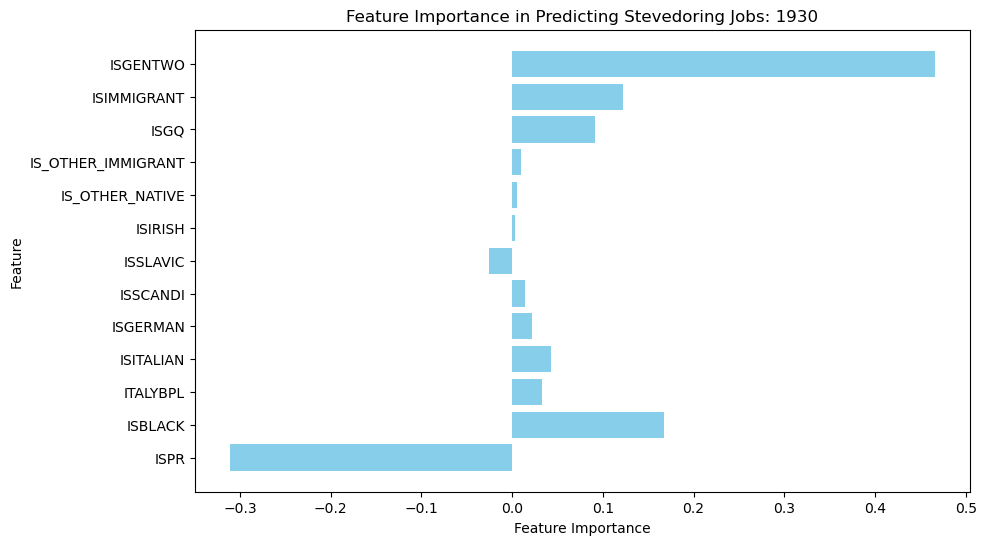

train_test_split on df_1940_redhook
boosted tree classifier on df_1940_redhook 
 -----------


/opt/anaconda3/envs/data/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/envs/data/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Accuracy: 0.8661925239827986 
 -----------
Confusion Matrix: 
 [[5236    4]
 [ 805    1]] 
 -----------
[0.06036841 0.0715161  0.02829453 0.03160456 0.05537535 0.0749583
 0.05783497 0.06488531 0.03704855 0.04815669 0.11741186 0.01398539
 0.09555998]


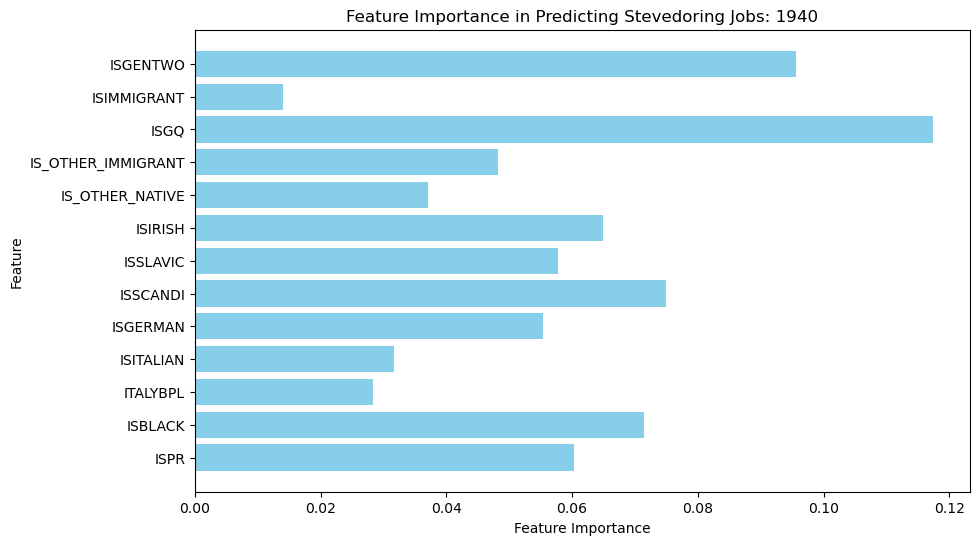

In [56]:
abc1900 = tree_boost_fit_predict(*tts(df_1900_redhook, 'df_1900_redhook'))
fi1900 = featureweights(abc1900, "1900")

abc1910 = tree_boost_fit_predict(*tts(df_1910_redhook, 'df_1910_redhook'))
fi1910 = featureweights(abc1910, "1910")

abc1920 = tree_boost_fit_predict(*tts(df_1920_redhook, 'df_1920_redhook'))
fi1920 = featureweights(abc1920, "1920")

abc1930 = tree_boost_fit_predict(*tts(df_1930_redhook, 'df_1930_redhook'))
fi1930 = featureweights(abc1930, "1930")

abc1940 = tree_boost_fit_predict(*tts(df_1940_redhook, 'df_1940_redhook'))
fi1940 = featureweights(abc1940, "1940")





It is difficult to tell why these negative importances are being produced, as these importances should all be positive. I am especially worried by the 'ISSLAVIC' negative importance in the last graph. This seems like the product of a substantial error. This could have resulted from the very few rows (3) that consist of slavic dockworkers, but I will have to look into it more.

### Explaining These Results

#### 1900

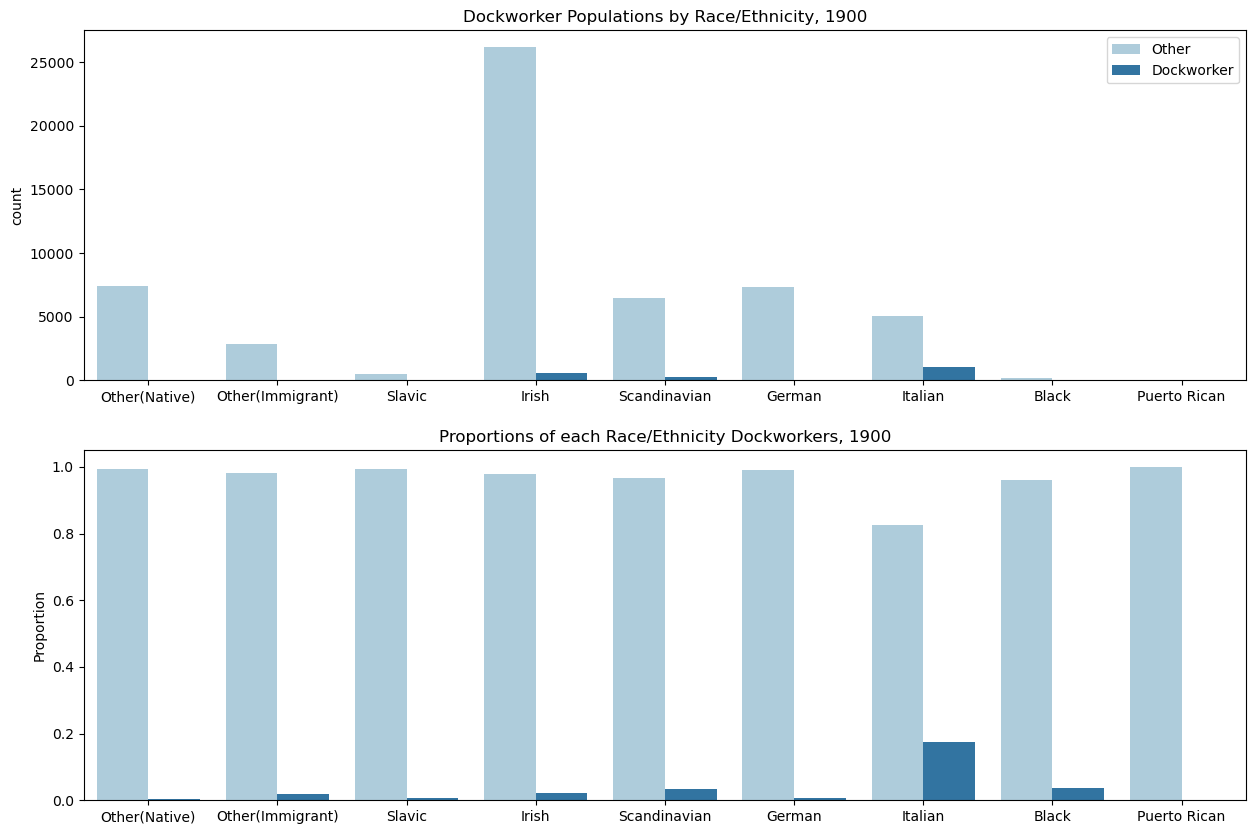

In [57]:
def plotwaterfrontproportions(df, label):

    fig, axes = plt.subplots(2, 1, figsize=(15, 10))

    # df = raisedockproportion(df)
    counts = df.groupby(['DEMO_GROUP', 'ISDOCKWORKER']).size().reset_index(name='Count')
    total_counts = df.groupby('DEMO_GROUP').size().reset_index(name='Total')
    counts = pd.merge(counts, total_counts, on='DEMO_GROUP')
    # counts['JOB_GROUP'].replace(to_replace=list(range(-1, 5)), 
    #                             value=['No Data', 'Unemployed', 'Non-Industrial', 'General Industry/Labor', 'Waterfront-Related Industry', 'Dockworker'],
    #                             inplace=True
    #                             )

    counts['Proportion'] = counts['Count'] / counts['Total']


    sns.countplot(data=df, x='DEMO_GROUP', hue='ISDOCKWORKER', palette='Paired', ax=axes[0])
    # axes[0].legend(labels=['No Data', 'Unemployed', 'Non-Industrial', 'General Industry/Labor', 'Waterfront-Related Industry', 'Dockworker'])
    axes[0].legend(labels=['Other', 'Dockworker'])

    axes[0].set_xticks(ticks=[0, 1, 2, 3, 4, 5, 6, 7, 8], labels=['Other(Native)', 'Other(Immigrant)', 'Slavic', 'Irish', 'Scandinavian', 'German', 'Italian', 'Black', 'Puerto Rican'])
    axes[0].set_title(F'Dockworker Populations by Race/Ethnicity, {label}')
    axes[0].set_xlabel('')

    sns.barplot(data=counts, x='DEMO_GROUP', y='Proportion', hue='ISDOCKWORKER', palette='Paired', ax=axes[1], legend=False)
    axes[1].set_xticks(ticks=[0, 1, 2, 3, 4, 5, 6, 7, 8], labels=['Other(Native)', 'Other(Immigrant)', 'Slavic', 'Irish', 'Scandinavian', 'German', 'Italian', 'Black', 'Puerto Rican'])
    axes[1].set_title(f'Proportions of each Race/Ethnicity Dockworkers, {label}')
    axes[1].set_xlabel('')

    plt.show()

plotwaterfrontproportions(df_1900_redhook, '1900')



This makes sense, as not a single Puerto Rican is a dockworker. At the same time, the Puerto Rican population is miniscule, so it's hard to imagine the differentialization to improve accuracy by much.

#### 1910 Features

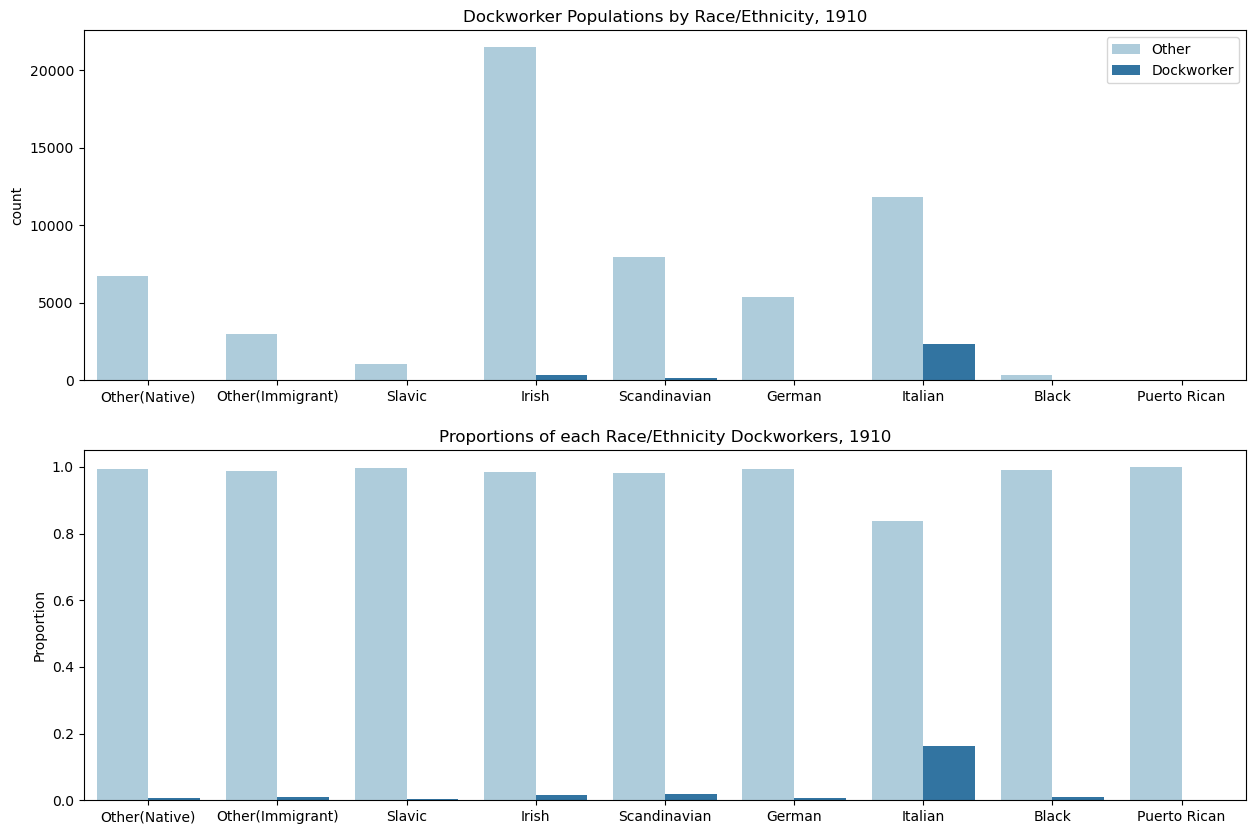

In [58]:
plotwaterfrontproportions(df_1910_redhook, '1910')

Again, no Puerto Rican Longshoremen, but again, very small sample size. If there were enough Longshoremen such that the model ever picked it, Differentiations such as Italian (Very High proportion of dockworkers), and German (disproportionately low proportion) would also probably have higher weights.

#### 1920 Features

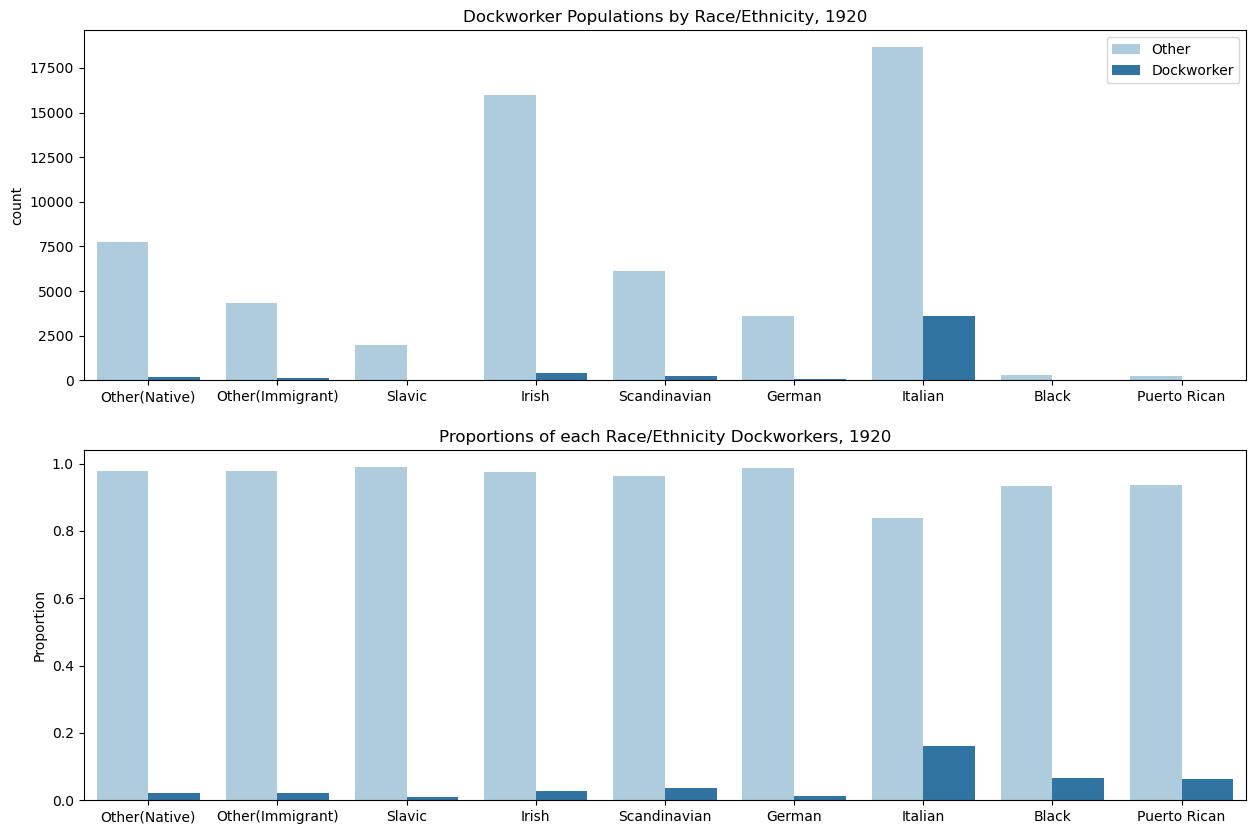

In [59]:
plotwaterfrontproportions(df_1920_redhook, '1920')


#### 1930

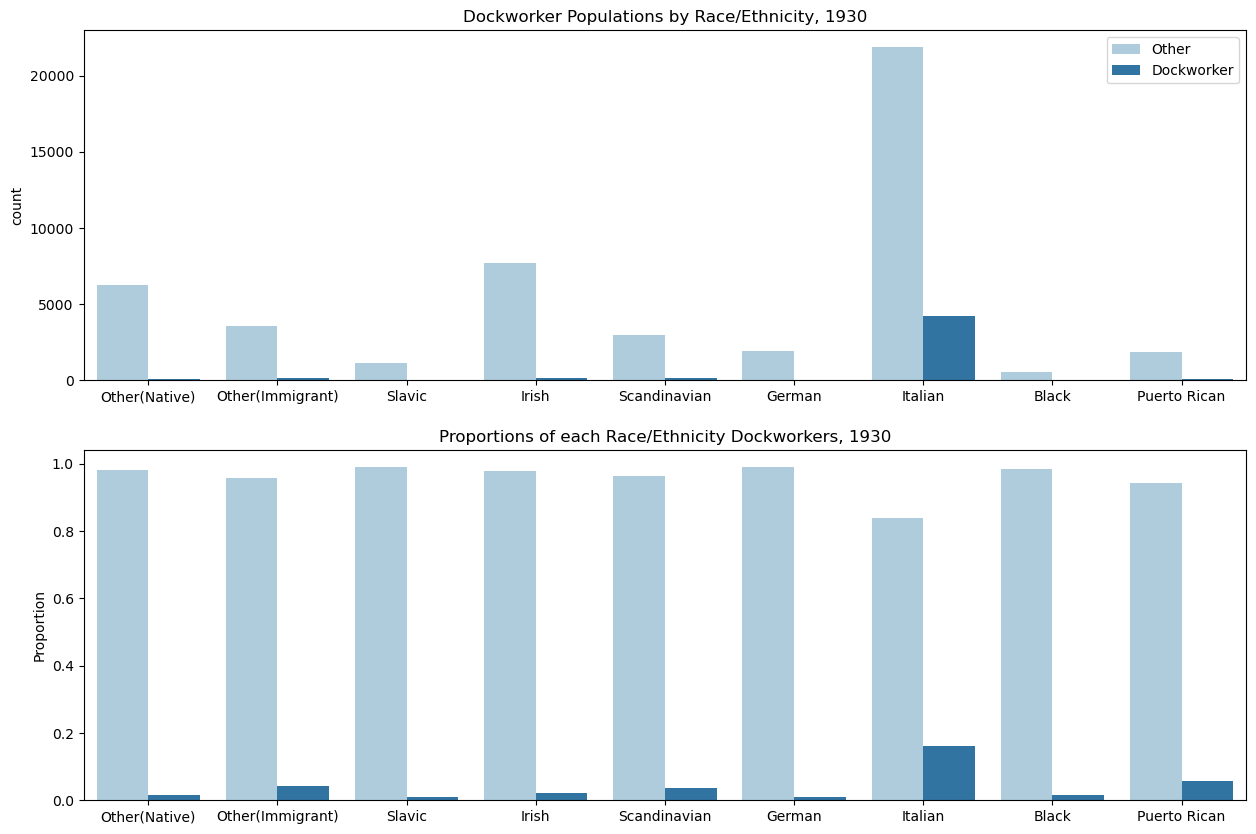

In [60]:
plotwaterfrontproportions(df_1930_redhook, '1930')

#### 1940

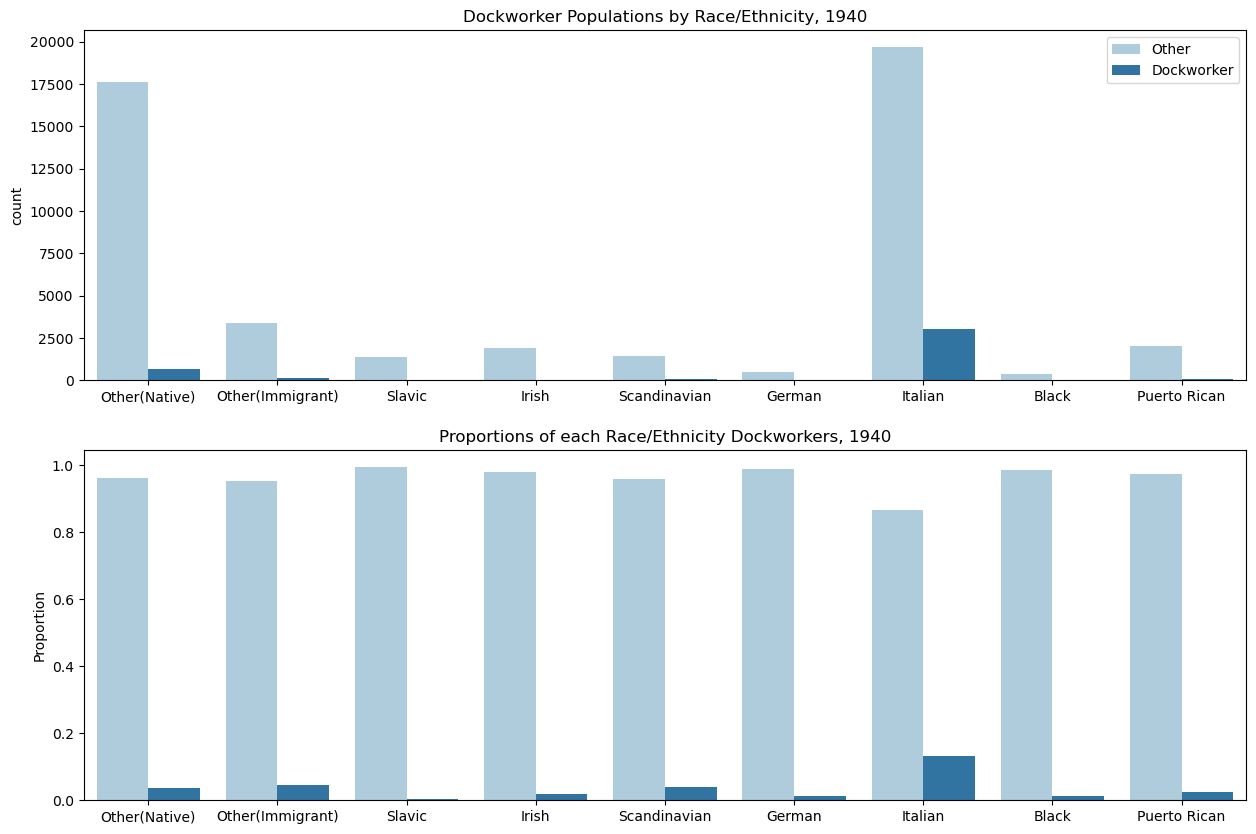

In [61]:
plotwaterfrontproportions(df_1940_redhook, '1940')

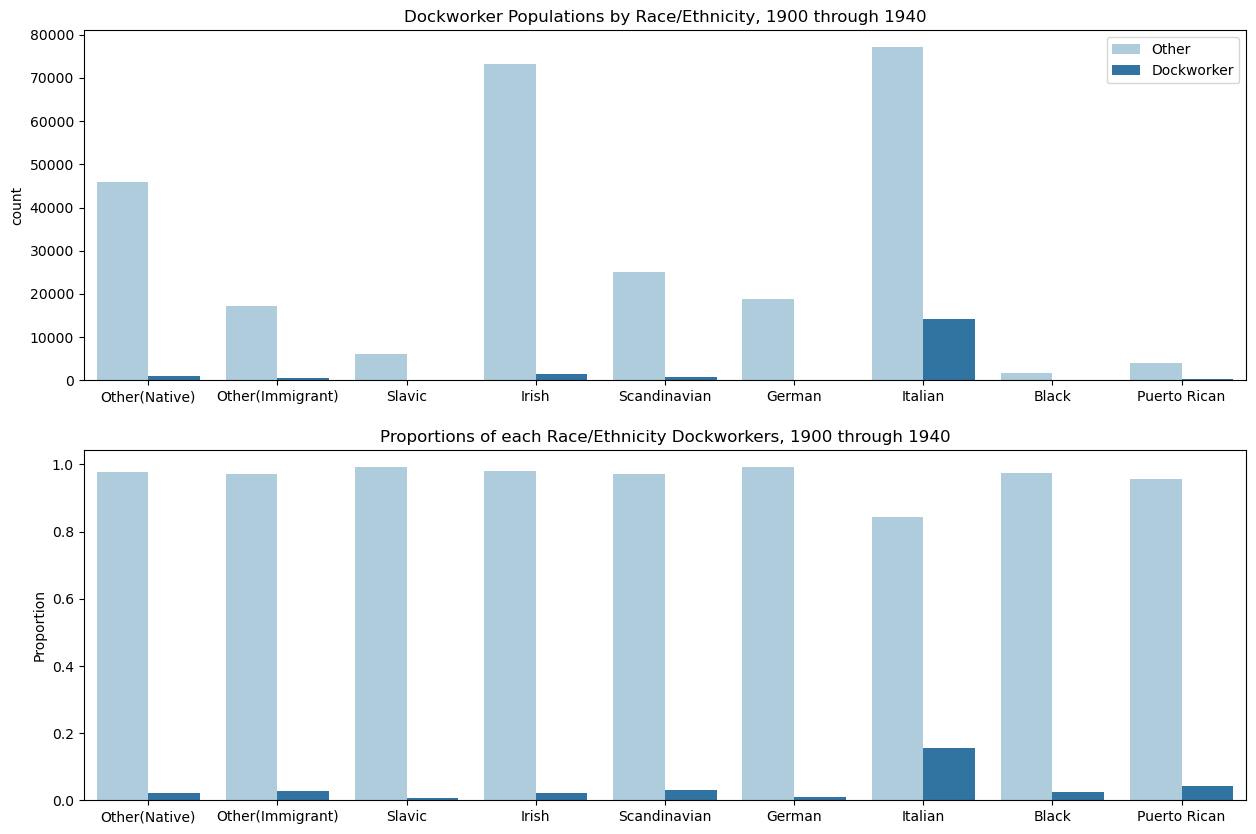

In [62]:
# and let's do one including all the decades!
plotwaterfrontproportions(df_redhook, '1900 through 1940')

#### Checking Other Demographic Features

In [63]:
def job_proportions_overtime(column, xticks, title):

    years = ['1900', '1910', '1920', '1930', '1940']
    dfs = [df_1900_redhook, df_1910_redhook, df_1920_redhook, df_1930_redhook, df_1940_redhook]

    fig, axes = plt.subplots(1, 5, figsize=(18, 5), sharey=True)
    # fig.tight_layout()

    for i, ax in enumerate(axes):
        counts = dfs[i].groupby(['ISDOCKWORKER', column]).size().reset_index(name='POP')
        totals = dfs[i].groupby(column).size().reset_index(name='TOTALPOP')
        counts = pd.merge(counts, totals, on=column)
        counts['Proportion'] = counts['POP'] / counts['TOTALPOP']
        # counts['JOB_GROUP'] = counts['JOB_GROUP'].replace(to_replace=[-1, 0, 1, 2, 3, 4], 
        #                             value=['No Data', 'Unemployed', 'Non-Industrial', 'General Industry/Labor', 'Waterfront-Related Industry', 'Dockworker'])

        if i == 0:
            sns.barplot(data=counts, hue='ISDOCKWORKER', x=column, y='Proportion', ax=ax, legend=True, palette='Paired')
        else: 
            sns.barplot(data=counts, hue='ISDOCKWORKER', x=column, y='Proportion', ax=ax, legend=False, palette='Paired')

        ax.set_title(years[i], weight='bold')
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.set_xticks(ticks=[False, True], labels=xticks)
        # ax.legend(labels=['No Data', 'Unemployed', 'Non-Industrial', 'General Industry/Labor', 'Waterfront-Related Industry', 'Dockworker'])
    
    plt.suptitle(title, fontsize=18, weight='bold')
    plt.show()

In [64]:
np.array(df_1910_redhook.columns)

array(['YEAR', 'SAMPLE', 'SERIAL', 'HHWT', 'STATEFIP', 'COUNTYICP', 'GQ',
       '1910label', 'PERNUM', 'SEX', 'AGE', 'RACE', 'RACED', 'HISPAN',
       'HISPAND', 'BPL', 'BPLD', 'MBPL', 'MBPLD', 'FBPL', 'FBPLD',
       'NATIVITY', 'OCC1950', 'IND1950', 'VERSIONHIST', 'HISTID',
       'MBPL_MOM', 'MBPL_POP', 'MBPL_MOM2', 'MBPL_POP2', 'FBPL_MOM',
       'FBPL_POP', 'FBPL_MOM2', 'FBPL_POP2', 'ISIMMIGRANT', 'ISGENTWO',
       'ISPR', 'ISWHITE', 'ISBLACK', 'ITALYBPL', 'ISITALIAN',
       'ISWHITE_NON_ITALIAN', 'ISGERMAN', 'ISSLAVIC', 'ISIRISH',
       'ISSCANDI', 'DEMO_GROUP', 'IS_OTHER_NATIVE', 'IS_OTHER_IMMIGRANT',
       'UNEMPLOYED', 'OCC_UNKNOWN', 'OCC_CATEGORY', 'OCC_PRO/TECH',
       'OCC_FARM', 'OCC_MAN/OFF/PROP', 'OCC_CLERICAL', 'OCC_SALES',
       'OCC_CRAFTS', 'OCC_OP', 'OCC_SERVICE', 'OCC_FARMLAB', 'OCC_LAB',
       'ISDOCKWORKER', 'ISWATERFRONT', 'ISINDUSTRY', 'JOB_GROUP', 'ISGQ',
       'ISPR_AND_UNEMPLOYED', 'ISPR_AND_OCC_UNKNOWN',
       'ISPR_AND_OCC_PRO/TECH', 'ISPR_AND_OC

### Final Correlations
Lets see how our other variables look in terms of basic correlation based on whether the variable is true/false!

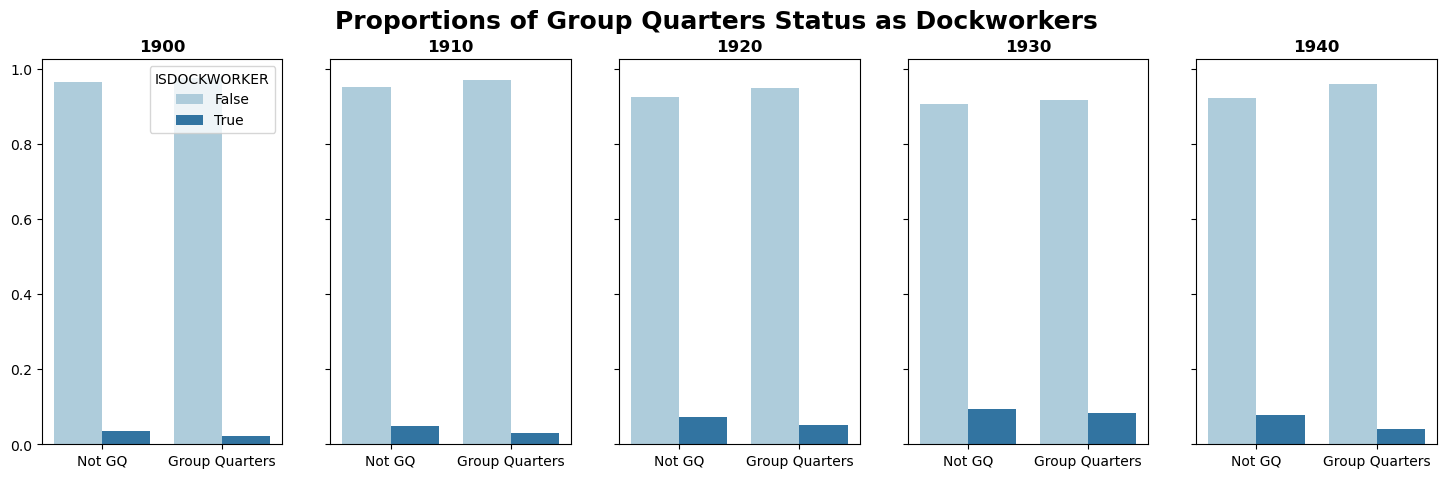

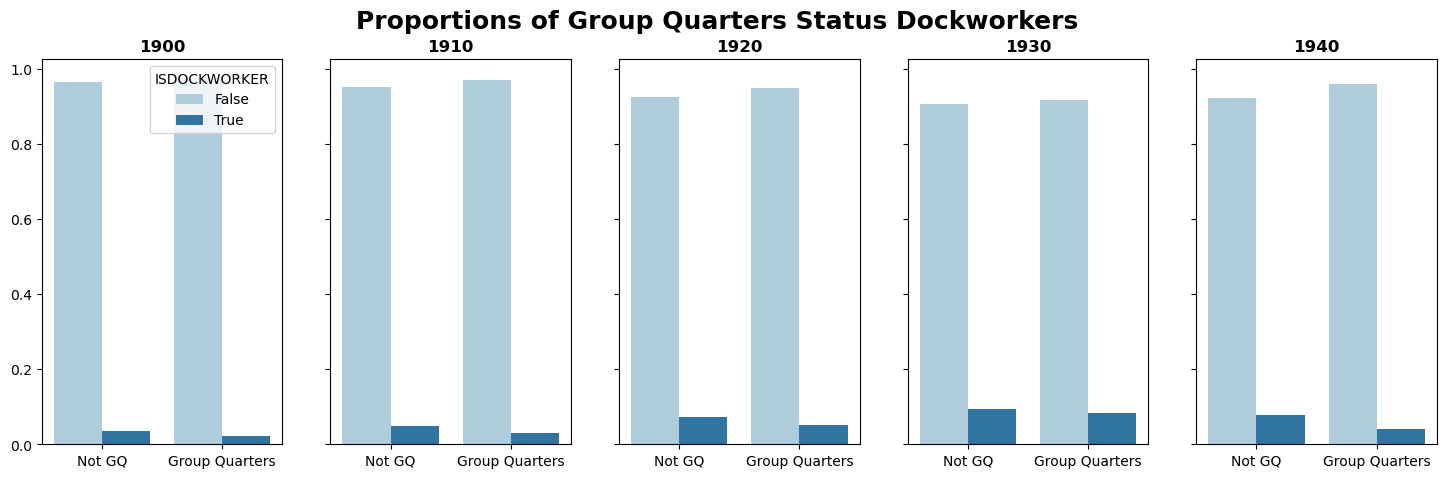

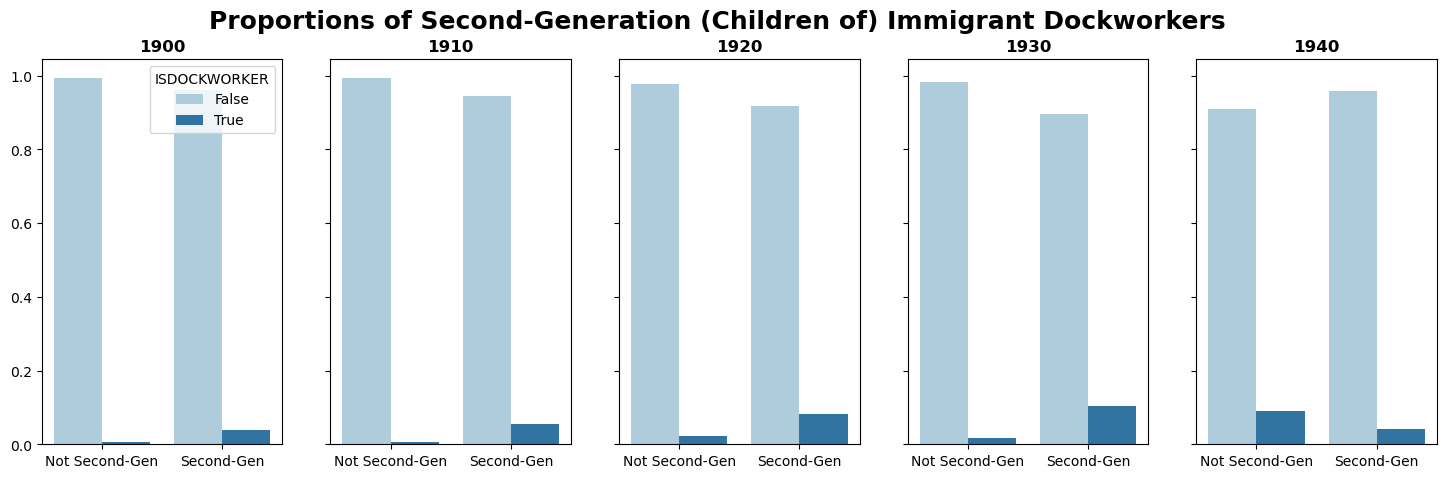

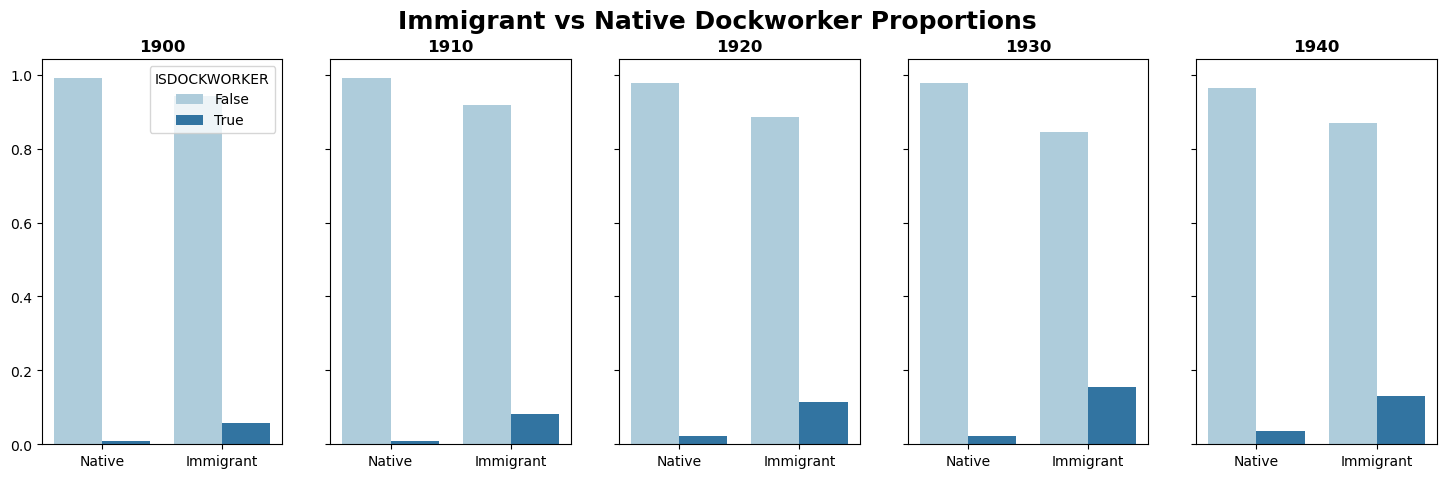

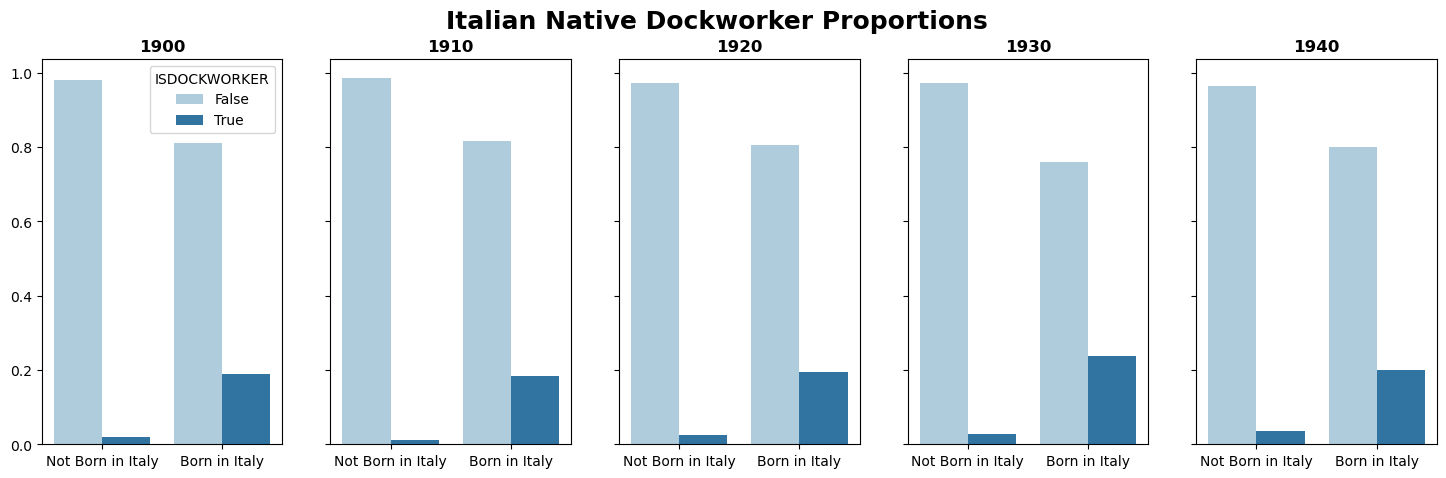

In [65]:
job_proportions_overtime('ISGQ', ['Not GQ', 'Group Quarters'], 'Proportions of Group Quarters Status as Dockworkers')
job_proportions_overtime('ISGQ', ['Not GQ', 'Group Quarters'], 'Proportions of Group Quarters Status Dockworkers')
job_proportions_overtime('ISGENTWO', ['Not Second-Gen', 'Second-Gen'], 'Proportions of Second-Generation (Children of) Immigrant Dockworkers')
job_proportions_overtime('ISIMMIGRANT', ['Native', 'Immigrant'], 'Immigrant vs Native Dockworker Proportions')
job_proportions_overtime('ITALYBPL', ["Not Born in Italy", "Born in Italy"], 'Italian Native Dockworker Proportions')